# COVID-19 Mitigation Measures Collateral Damage Assesment 

In this project i will determine which factors are most relevant for the reprodduction of the SARS-CoV2 virus in Austria, built a SIR-based model to simulate various scenarios for different stringency of mitigation measures and then try to estimate the collateral damage by said measures. End product is an estimate for collateral damage of measures and effectiveness in containing the virus

In [1]:
import os
import requests
from pprint import pprint
import covsirphy as cs
import pandas as pd
import numpy as np
import datetime
from operator import add

import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import ttest_ind
from scipy import signal
from scipy.stats import boxcox
from scipy.stats import normaltest

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_log_error


import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27*0.75)})

In [2]:
# Some Sources:
# https://www.who.int/bulletin/online_first/BLT.20.265892.pdf
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333368/

## 1. Data Preparation and Exploration

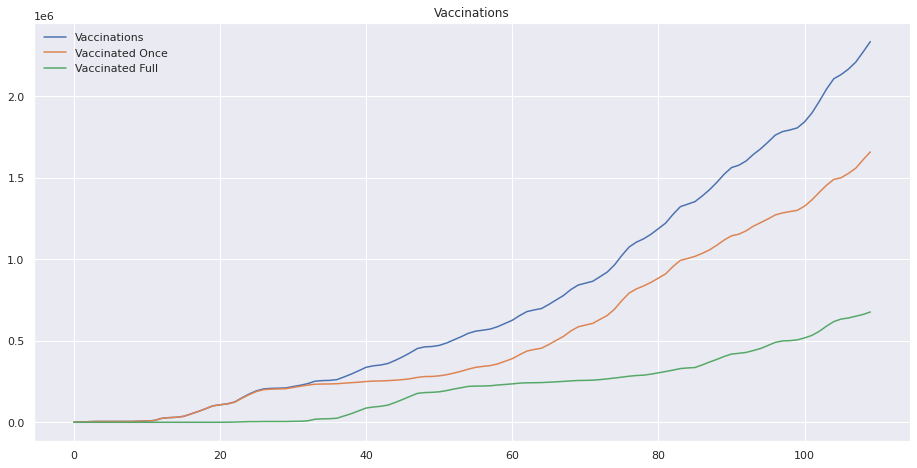

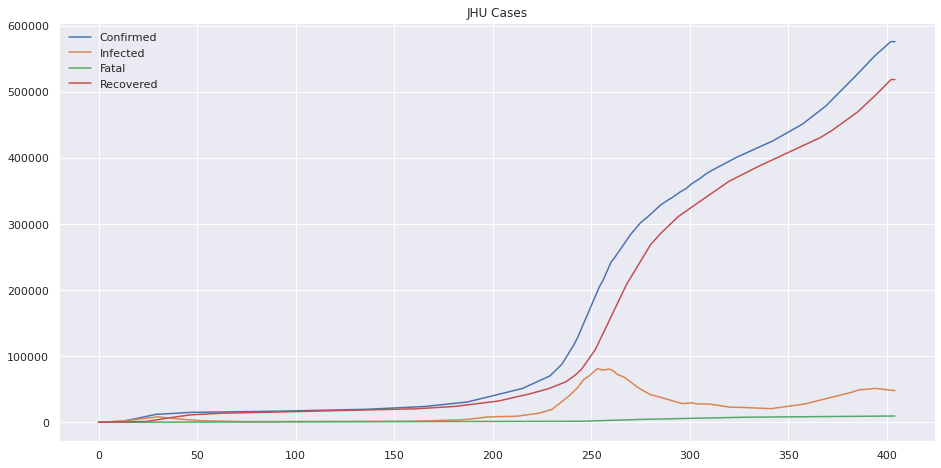

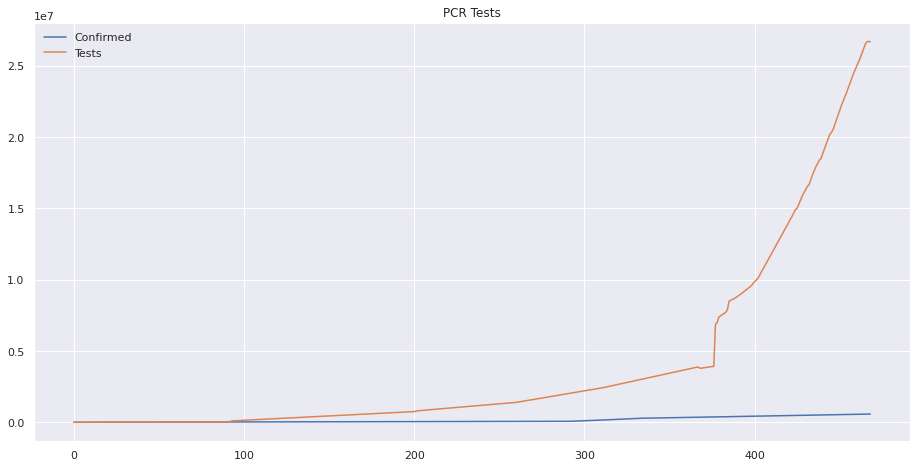

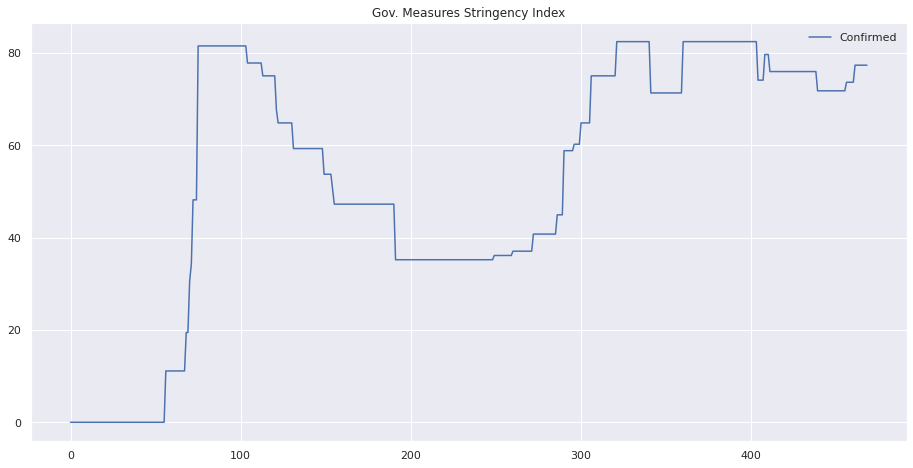

          Date  Population
0   2020-01-01     8840521
1   2020-01-02     8840521
2   2020-01-03     8840521
3   2020-01-04     8840521
4   2020-01-05     8840521
..         ...         ...
464 2021-04-09     8840521
465 2021-04-10     8840521
466 2021-04-11     8840521
467 2021-04-12     8840521
468 2021-04-13     8840521

[469 rows x 2 columns]


In [3]:
#Get data
data_loader = cs.DataLoader("../input")
jhu_data = data_loader.jhu() #Cases (JHU)
population_data = data_loader.population() # Population
oxcgrt_data = data_loader.oxcgrt() # Government Response (OxCGRT)
pcr_data = data_loader.pcr() # Tests
vaccine_data = data_loader.vaccine() # Vaccinations
#print(vaccine_data.subset("Austria"))
plt.plot(vaccine_data.subset("Austria")['Vaccinations'], label='Vaccinations')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_once'], label='Vaccinated Once')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_full'], label='Vaccinated Full')
plt.title('Vaccinations')
plt.legend()
plt.show()

#print(jhu_data.subset("Austria"))
plt.plot(jhu_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(jhu_data.subset("Austria")['Infected'], label='Infected')
plt.plot(jhu_data.subset("Austria")['Fatal'], label='Fatal')
plt.plot(jhu_data.subset("Austria")['Recovered'], label='Recovered')
plt.title('JHU Cases')
plt.legend()
plt.show()

#print(pcr_data.subset("Austria"))
plt.plot(pcr_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(pcr_data.subset("Austria")['Tests'], label='Tests')
plt.title('PCR Tests')
plt.legend()
plt.show()

#print(oxcgrt_data.subset("Austria"))
plt.plot(oxcgrt_data.subset("Austria")['Stringency_index'], label='Confirmed')
plt.title('Gov. Measures Stringency Index')
plt.legend()
plt.show()

country = "Austria"
aut_cov = jhu_data.subset("Austria")
aut_pop = population_data.subset("Austria")
aut_gov = oxcgrt_data.subset("Austria")
aut_pcr = pcr_data.subset("Austria")
aut_vac = vaccine_data.subset("Austria") 
print(aut_pop)

age 0 to 9
age 10 to 19
age 20 to 29
age 30 to 39
age 40 to 49
age 50 to 59
age 60 to 69
age 70 to 79
age 80 to 89
age 90 to 99
age 100 to 109
8901064
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              49.00
Date:                Sun, 18 Apr 2021   Prob (F-statistic):                    7.65e-05
Time:                        16:57:04   Log-Likelihood:                          17.143
No. Observations:                   9   AIC:                                     -30.29
Df Residuals:                       7   BIC:                                     -29.89
Df Model:                           2                                                  
Covariance Type:            nonrobust                    

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


AltersgruppeID
1        [<5]
2      [5-14]
3     [15-24]
4     [25-34]
5     [35-44]
6     [45-54]
7     [55-64]
8     [65-74]
9     [75-84]
10      [>84]
Name: Altersgruppe, dtype: object
                Anzahl AnzahlGeheilt AnzahlTot AnzEinwohner Altersgruppe  \
AltersgruppeID                                                             
1                 6797          6011         0       435835         [<5]   
2                42819         38342         1       847225       [5-14]   
3                84016         77645         6       955625      [15-24]   
4                95123         88080        11      1209030      [25-34]   
5                88810         82055        27      1174745      [35-44]   
6               103079         95830       135      1333857      [45-54]   
7                78968         73018       509      1251120      [55-64]   
8                38291         34180      1314       842035      [65-74]   
9                31844         26659      3302     

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


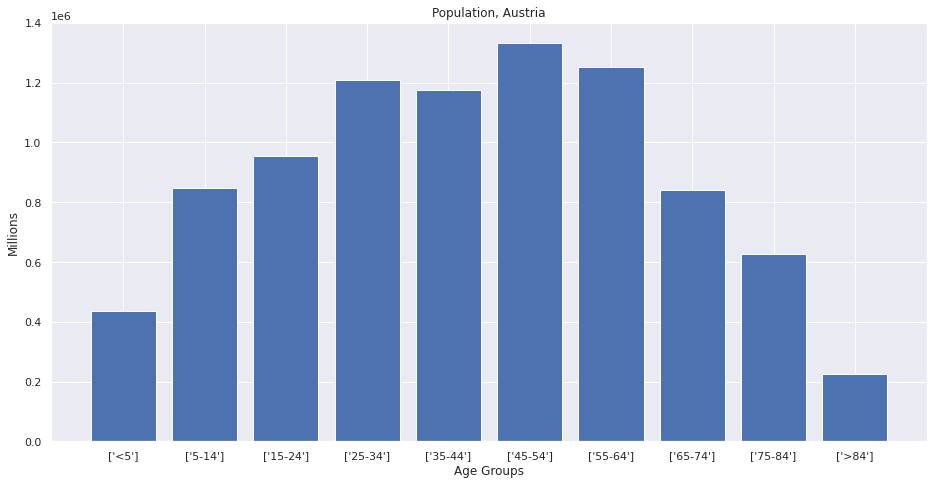

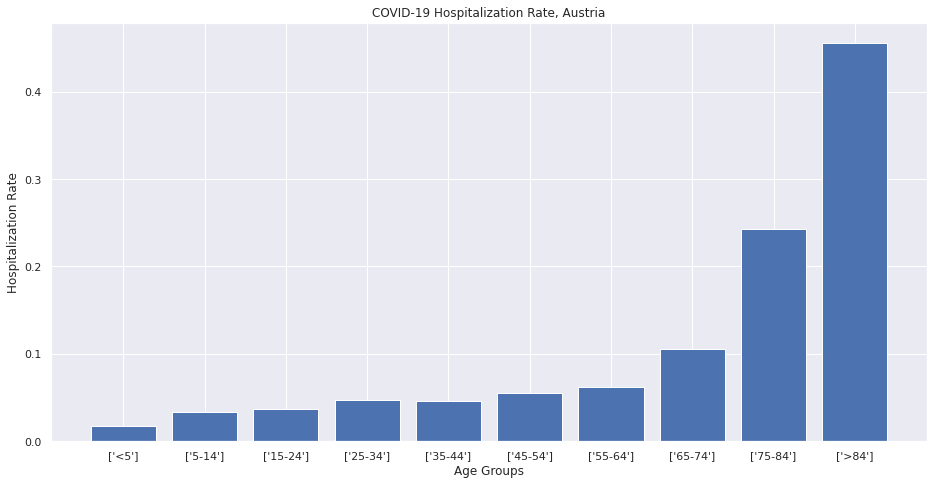

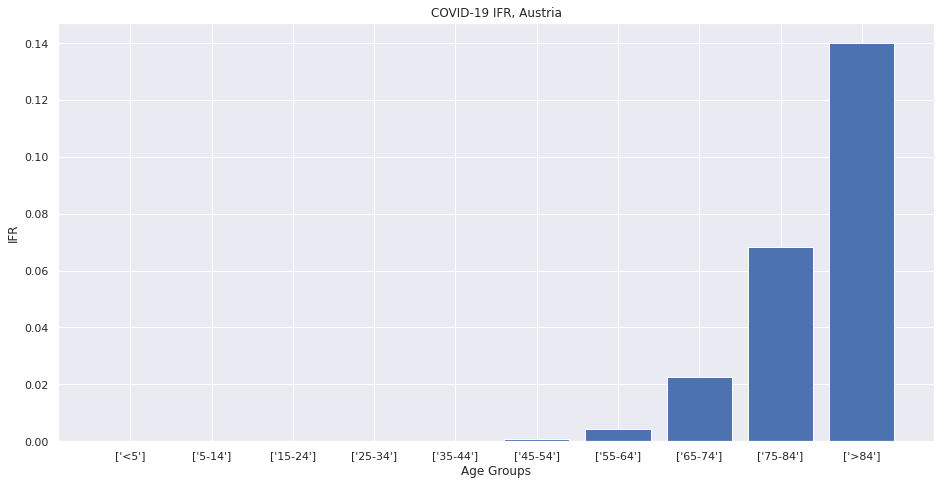

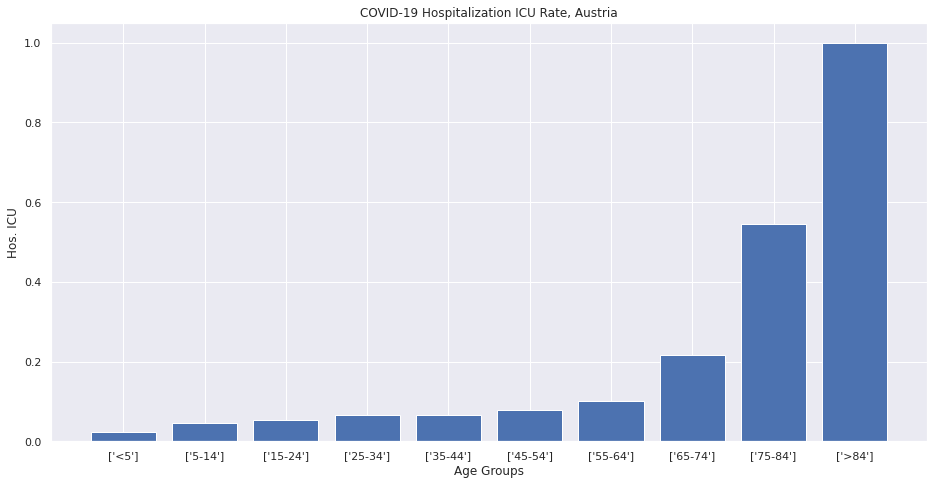

In [235]:
'''
Für die Todesrate von Krankheiten gibt es laut WHO zwei verschiedene wichtige Kennzahlen. 
Mit dem „Fall-Verstorbenen-Anteil” (CFR) wird berechnet, wie viele Todesfälle unter 
allen positiv getesteten Erkrankten zu verzeichnen sind. 
Beim „Infizierten-Verstorbenen-Anteil” (IFR) wird die Zahl der Todesfälle der geschätzten Zahl 
an Gesamtinfizierten gegenübergestellt. Dadurch werden auch Infizierte erfasst, 
die keine oder kaum Symptome aufzeigen und nicht getestet wurden.
'''

# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf

from zipfile import ZipFile
# Population
# https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/bevoelkerungsstruktur/bevoelkerung_nach_alter_geschlecht/index.html
dfs = pd.read_excel("./data/bevoelkerung_am_1.1.2020_nach_alter_und_bundesland_-_insgesamt.xlsx", sheet_name=None)
dfs = dfs['Insgesamt'][['Bevölkerung am 1.1.2020 nach Alter und Bundesland - Insgesamt', 'Unnamed: 1']].loc[4:104]
dfs = dfs.reset_index(drop=True)

pop_groups = []
for i in range(0,104,10):
    print('age',i,'to',i+9)
    pop_groups.append(dfs['Unnamed: 1'].loc[i:i+9].sum())

pp80 = sum(pop_groups[-3:])
pop_groups = pop_groups[:-3]
pop_groups.append(pp80)
assert(sum(pop_groups)==dfs['Unnamed: 1'].sum())
print(sum(pop_groups))

#Some Data from birtain -  we will try to obtain hosp rates, icu rates from that data for austria
# Source:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
pop_groups_ifr = [0.00002, 0.00006, 0.0003, 0.0008, 0.0015, 0.006, 0.022, 0.051, 0.093]
pop_groups_hosp = [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]
pop_groups_hosp_icu = [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.274, 0.432, 0.703]

#print(pop_groups)
#print(pop_groups_ifr)
#print(pop_groups_hosp)
#print(pop_groups_hosp_icu)

mod = sm.OLS(pop_groups_hosp, np.array([pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
#res.predict(np.array([pop_groups_ifr, pop_groups]).T)
        
# Get IFRs, etc for austria
# https://flexikon.doccheck.com/de/Infection_fatality_rate
url = 'https://covid19-dashboard.ages.at/data/data.zip'
save_path = './data/ages/data.zip'

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url, save_path)
with ZipFile('./data/ages/data.zip', 'r') as zipObj:
    zipObj.extractall(path='./data/ages/')

aut_age_groups = pd.read_csv("./data/ages/CovidFaelle_Altersgruppe.csv", sep=';', index_col = 0, header = 0)

print(aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique())


aut_age_groups = pd.DataFrame(
    [aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Anzahl.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlGeheilt.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlTot.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzEinwohner.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique()
    ]
).T#.reset_index(drop=True)

# Percentage asymptomatic cases:
# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf
aut_age_groups['CFR'] = aut_age_groups.AnzahlTot/aut_age_groups.Anzahl
aut_age_groups['IFR'] = aut_age_groups['CFR']*(1-0.34) #percentage of asymptomatic
aut_age_groups['Hosp'] = np.clip(
    res.predict(np.array([aut_age_groups['IFR'], aut_age_groups['AnzEinwohner']]).T),
    0.0,1.0)
print(aut_age_groups)

aut_hosp_groups = pd.read_csv("./data/ages/CovidFallzahlen.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} )
print(aut_hosp_groups.head(15))

aut_hosp_groups = pd.DataFrame(
    [aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZHosp,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZHospFree,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZICU,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZICUFree,
    ]
).T


mod = sm.OLS(pop_groups_hosp_icu, np.array([pop_groups_hosp, pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
aut_age_groups['Hosp_ICU'] = np.clip(res.predict(np.array([
                                aut_age_groups['Hosp'],
                                aut_age_groups['IFR'], 
                                aut_age_groups['AnzEinwohner']]).T), 0.0, 1.0)
    

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)

plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, aut_age_groups['AnzEinwohner'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()


plt.xlabel('Age Groups')
plt.ylabel('Hospitalization Rate')
plt.title('COVID-19 Hospitalization Rate, Austria')
plt.bar(x, aut_age_groups['Hosp'], 
        tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 IFR, Austria')
plt.bar(x, aut_age_groups['IFR'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('Hos. ICU')
plt.title('COVID-19 Hospitalization ICU Rate, Austria')
plt.bar(x, aut_age_groups['Hosp_ICU'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()
        
pop_groups_hosp_icu = aut_age_groups['Hosp_ICU'].to_numpy()
pop_groups_hosp = aut_age_groups['Hosp'].to_numpy()
pop_groups_ifr = aut_age_groups['IFR'].to_numpy()
pop_groups = aut_age_groups['AnzEinwohner'].to_numpy()

         Date  Vaccinations  Vaccinated_once  Vaccinated_full
0  2020-12-27           732              732                0
1  2020-12-28          2029             2029                0
2  2020-12-29          3648             3648                0
3  2020-12-30          4996             4996                0
4  2020-12-31          5004             5004                0
5  2021-01-01          5008             5008                0
6  2021-01-02          5014             5014                0
7  2021-01-03          5015             5015                0
8  2021-01-04          5131             5131                0
9  2021-01-05          6921             6921                0
10 2021-01-06          7754             7754                0
11 2021-01-07         10930            10930                0
12 2021-01-08         23886            23886                0
13 2021-01-09         28289            28289                0
14 2021-01-10         30509            30509                0
15 2021-

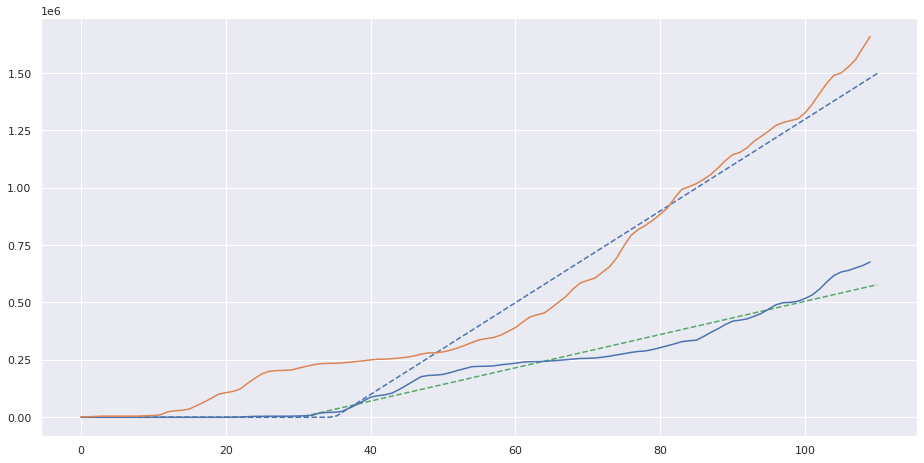

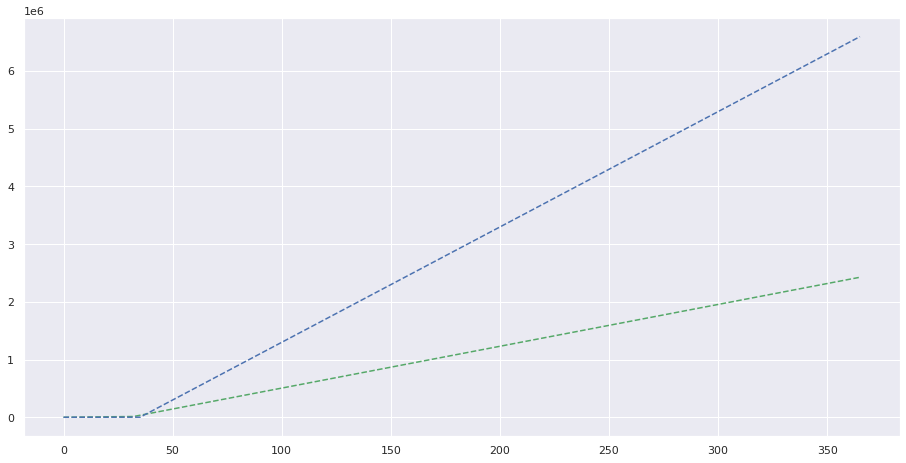

20033.016152648255 7263.294717780314


In [423]:
# Vaccines
print(aut_vac.head(25))
vac_full_data = aut_vac['Vaccinated_full'].to_numpy()
vac_once_data = aut_vac['Vaccinated_once'].to_numpy()
# plt.plot(aut_vac['Vaccinated_full'].to_numpy())

# Start Date is 2020-12-27 for vaccinated once, 
# 2021-01-15 for vaccinated
# 307 days and XXX days after start of pandemic in Austria on 25.02.2020

# Next we fit a 4th degree polynomial to the vaccinations curve using least squares method
# so we can estimate future vaccinations progress.

#poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**2) + e
#def func(x, a, b, c, d, e):
#    y = poly4(x, a, b, c, d, e)
#    return np.abs(y*(y>0))
    
#poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0) 
#def func(x, a, b, c, d):
#    y = poly3(x, a, b, c, d)
#    return np.abs(y*(y>0))

#poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
#def func(x, a, b, c):
#    y = poly2(x, a, b, c)
#    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_full(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_once(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))
    
    

xdata = np.linspace(0,1,len(vac_full_data))*len(vac_full_data)
popt_full, pcov_full = curve_fit(vac_full, xdata, vac_full_data, method='lm')

xdata = np.linspace(0,1,len(vac_once_data))*len(vac_once_data)
popt_once, pcov_once = curve_fit(vac_once, xdata, vac_once_data, method='lm')

# Check quality of fit with R2
print(r2_score(vac_full(xdata, *popt_full), vac_full_data))
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.plot(vac_full_data)
plt.plot(vac_once_data)
plt.show()

# Predict a whole year of vaccinations and see how it looks like:
dur = 365
xdata = np.linspace(0,1,dur)*dur
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.show()

vac_full_curve = vac_full(xdata, *popt_full)
vac_full_per_day = vac_full_curve[-1]-vac_full_curve[-2]

vac_once_curve = vac_once(xdata, *popt_once)
vac_once_per_day = vac_once_curve[-1]-vac_once_curve[-2]
print(vac_once_per_day, vac_full_per_day)

               R_eff  R_eff_lwr  R_eff_upr
Datum                                     
2020-03-10  2.724623   2.364393   3.110021
2020-03-11  3.158794   2.817445   3.519379
2020-03-12  3.073370   2.781653   3.379425
2020-03-13  3.266824   3.007643   3.536563
2020-03-14  3.214620   2.994746   3.442174


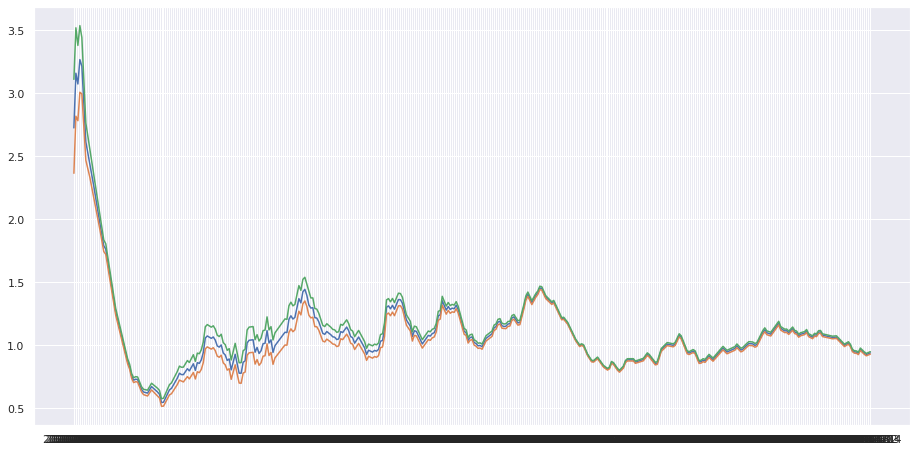

In [6]:
# Effective reproduction number, etc AGES
# https://www.ages.at/en/wissen-aktuell/publikationen/epidemiologische-parameter-des-covid19-ausbruchs-oesterreich-20202021/

urls = ['https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/growth.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/meta_data.csv'
    ]

for url in urls:
    with open('./data/ages/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

aut_reff = pd.read_csv("./data/ages/R_eff.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} ) 
aut_reff[0:]=aut_reff[0:].replace({',' : '.'}, regex=True).astype(float)
print(aut_reff.head())

plt.plot(aut_reff['R_eff'], label='R_eff')
plt.plot(aut_reff['R_eff_lwr'], label='R_eff_lwr')
plt.plot(aut_reff['R_eff_upr'], label='R_eff_upr')
plt.show()

Int64Index([202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
            202011, 202012, 202101, 202102, 202103],
           dtype='int64', name='REF_DATE')
Index(['NUTS1', 'NUTS2', 'NUTS3', 'DISTRICT_CODE', 'SUB_DISTRICT_CODE', 'T',
       'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'NUM_ICE',
       'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H', 'NUM_CLEAR',
       'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN', 'WIND_VEL',
       'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01',
       'STAT_NUM', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


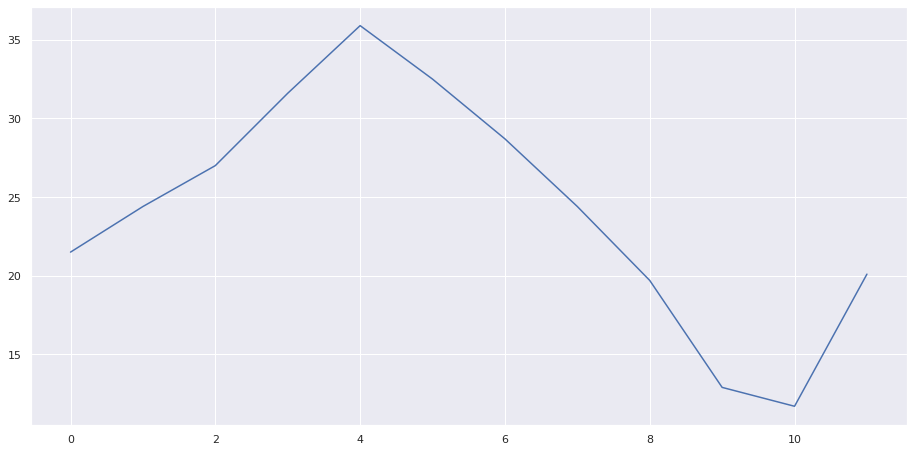

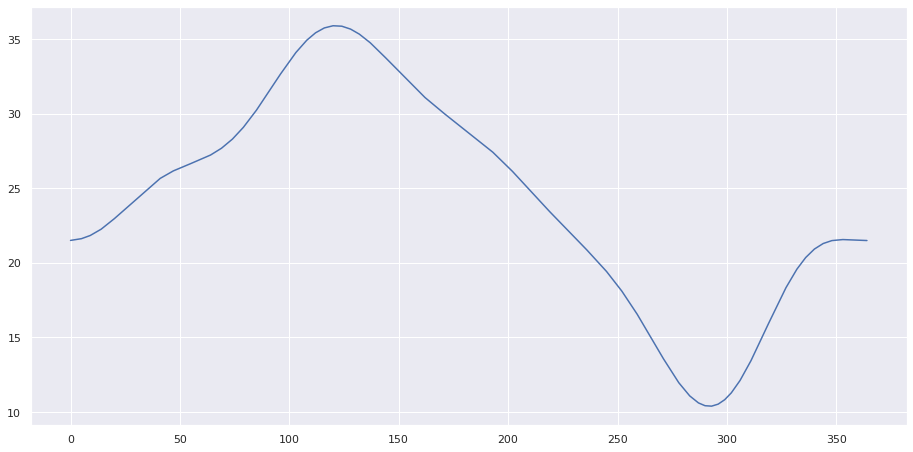

In [7]:
# Some papers suggest association between temperatures and virus spread
# https://repositum.tuwien.at/bitstream/20.500.12708/17056/1/Prager%20Lukas%20-%202021%20-%20Examining%20Austrian%20COVID-19%20Data%20in%20the%20Context%20of%20Linear...pdf#%5B%7B%22num%22%3A1106%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C72%2C628.0339966%2Cnull%5D
# https://www.sciencedirect.com/science/article/pii/S0048969720379213
# https://www.sciencedirect.com/science/article/pii/S1201971220302848

url = 'https://www.wien.gv.at/gogv/l9ogdwetter'
with open('./data/wiengv/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())
            
aut_weather= pd.read_csv("./data/wiengv/l9ogdwetter", sep=';', index_col = 0, header = 1)
aut_weather[aut_weather.columns[5:29]] = aut_weather[aut_weather.columns[5:29]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[782:]) #which rows to select for data since march 1 2020
print(aut_weather.columns)
X_w = aut_weather[aut_weather.columns[6]].iloc[782:782+12].to_numpy()
plt.plot(X_w)
plt.show()
X_w = signal.resample(X_w, aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])
plt.plot(X_w)
plt.show()

#avg over last 3 yrs
#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-12:782-12+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-24:782-24+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w= X_w/3

#plt.plot(X_w)
#plt.show()

## Regression analysis of variables

In [8]:
# Remove Colinear Variables
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
# https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = []
        for ix in range(X.iloc[:, variables].shape[1]):
            try:
                vif_ix = variance_inflation_factor(X.iloc[:, variables].values, ix)
                vif.append(vif_ix)
            except:
                vif.append(thresh+1.0)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [9]:
# Regression analysis
# Goodness of fit --> R2
# Significance F-Test overall, t-tests individual params.
# Evaluate OLS model on all features via F/t-testing
# Interpretation:
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# https://en.wikipedia.org/wiki/Regression_analysis

# Effective reproduction number
y = aut_reff['R_eff'].iloc[0:365].to_numpy()
y_lwr = aut_reff['R_eff_lwr'].iloc[0:365].to_numpy()
y_upr = aut_reff['R_eff_upr'].iloc[0:365].to_numpy()

# Pandemic
X_p = pd.DataFrame(aut_cov['Infected'].iloc[0:365], columns=['Infected'])
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Fatal'].iloc[0:365], columns=['Fatal'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Recovered'].iloc[0:365], columns=['Recovered'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Confirmed'].iloc[0:365], columns=['Confirmed'])), axis=1)

# Gov. measures from oxford tracker
X_g = aut_gov[69:(69+365)][aut_gov.columns[1:]].reset_index(drop=True) #10 march
      
# Weather data from Hohe Warte (ZAMG unfortunately has a paywall...)
X_w = aut_weather.iloc[782:][aut_weather.columns[5:28]]
X_w = signal.resample(X_w, y.shape[0])
X_w = pd.DataFrame(X_w, columns = aut_weather.columns[5:28])
X_w_c = calculate_vif_(X_w) # Remove multicolinear columns from weather data 

# Merge datasets analyse them togather
X_wgp = pd.concat((X_w, X_g, X_p), axis=1)
X_wg = pd.concat((X_w, X_g), axis=1)
X_gp = pd.concat((X_g, X_p), axis=1)
X_wp = pd.concat((X_w, X_p), axis=1)

X_w_cgp = pd.concat((X_w_c, X_g, X_p), axis=1)
X_w_cg = pd.concat((X_w_c, X_g), axis=1)
X_w_cp = pd.concat((X_w_c, X_p), axis=1)

dropping 'T' at index: 0
dropping 'T_MAX' at index: 0
dropping 'T_MIN' at index: 0
dropping 'MEAN_T_MAX' at index: 0
dropping 'MEAN_T_MIN' at index: 0
dropping 'NUM_FROST' at index: 0
dropping 'NUM_ICE' at index: 0
dropping 'NUM_SUMMER' at index: 0
dropping 'NUM_HEAT' at index: 0
dropping 'P' at index: 0
dropping 'P_MIN' at index: 1
dropping 'P_MAX' at index: 0
dropping 'REL_HUM_MAX' at index: 4
dropping 'REL_HUM' at index: 3
dropping 'WIND_VEL' at index: 4
dropping 'WIND_VEL_MAX' at index: 5
dropping 'NUM_PRECP_01' at index: 6
dropping 'REL_HUM_MIN' at index: 3
dropping 'SUN_H' at index: 0
dropping 'NUM_WIND_VEL60' at index: 2
Remaining variables:
Index(['NUM_CLEAR', 'NUM_CLOUD', 'PRECP_SUM'], dtype='object')


In [10]:
'''
# Analyse all datsets seperately w.r.t Reproduction
x = np.linspace(0, 365, 365)
dependent = {'R_lwr': y_lwr, 'R': y, 'R_upr': y_upr}
independent = {'X_w': X_w, 'X_p': X_p, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wgp' : X_wgp, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_wp' : X_wp, 'X_w_cgp' : X_w_cgp,
               'X_w_cg' : X_w_cg, 'X_w_cp': X_w_cp}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
        
# ...w.r.t pandemic curve
dependent = {'Fatal': X_p['Fatal'], 'Infected': X_p['Infected'], 
             'Recovered': X_p['Recovered'], 'Confirmed' : X_p['Confirmed']}
independent = {'X_w': X_w, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_w_cg' : X_w_cg}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
'''

'\n# Analyse all datsets seperately w.r.t Reproduction\nx = np.linspace(0, 365, 365)\ndependent = {\'R_lwr\': y_lwr, \'R\': y, \'R_upr\': y_upr}\nindependent = {\'X_w\': X_w, \'X_p\': X_p, \'X_g\': X_g,\n               \'X_w_c\' : X_w_c, \'X_wgp\' : X_wgp, \'X_wg\' : X_wg, \n               \'X_gp\' : X_gp, \'X_wp\' : X_wp, \'X_w_cgp\' : X_w_cgp,\n               \'X_w_cg\' : X_w_cg, \'X_w_cp\': X_w_cp}\nfor X_key in independent:\n    for y_key in dependent:\n        print("{}, {}".format(X_key, y_key))\n        mod = sm.OLS(dependent[y_key], independent[X_key])\n        res = mod.fit()\n        print(res.summary())\n\n        prstd, iv_l, iv_u = wls_prediction_std(res)\n        y_pred = res.predict(independent[X_key])\n        fig, ax = plt.subplots(figsize=(8,6))\n        ax.plot(x, y_pred, \'o\', label="data")\n        ax.plot(x, dependent[y_key], \'b-\', label="True")\n        ax.plot(x, res.fittedvalues, \'r--.\', label="OLS")\n        ax.plot(x, iv_u, \'r--\')\n        ax.plot(x, i

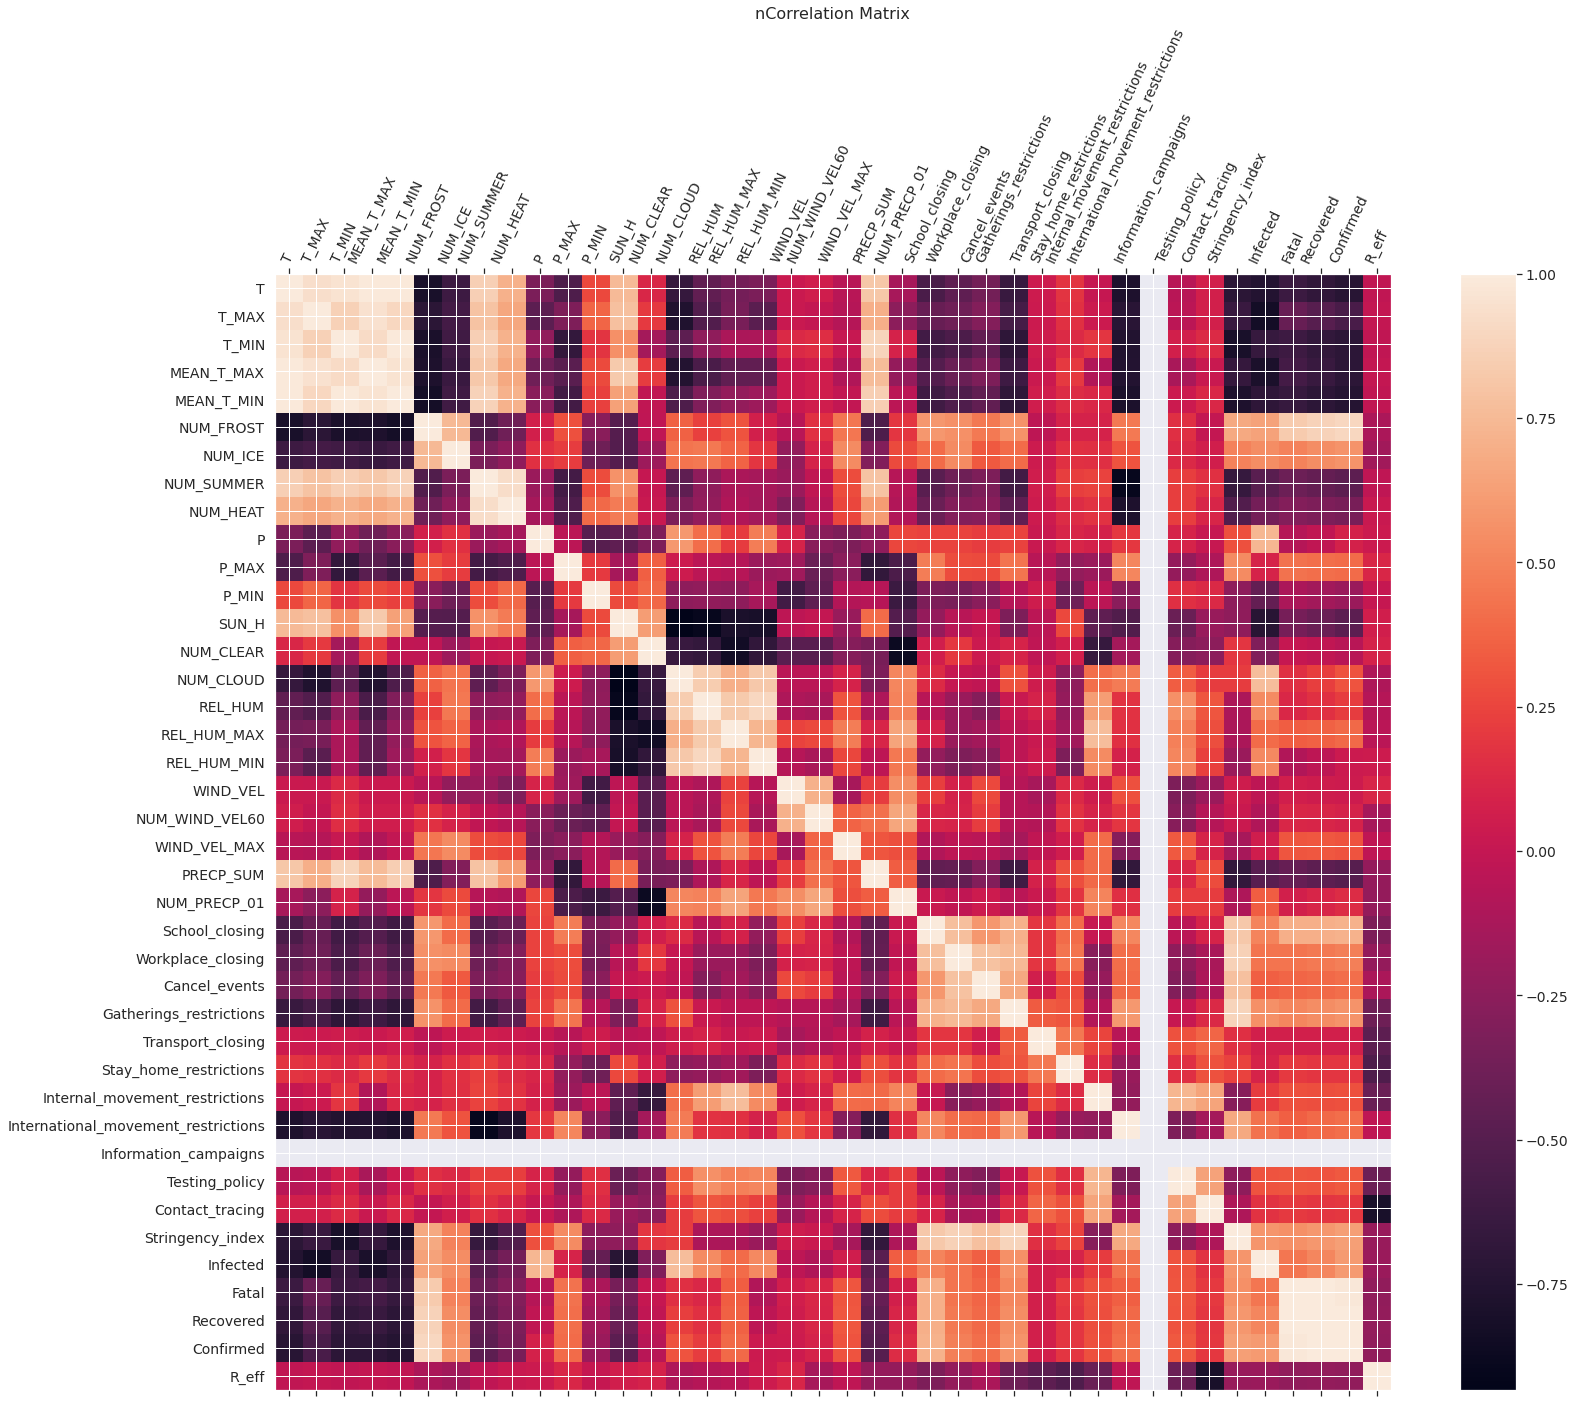

In [11]:
# Explore X, y datasets visually
Xy = pd.concat((X_wgp, pd.DataFrame(y, columns=['R_eff'])), axis=1)
Xy.reset_index(drop=True, inplace=True)

f = plt.figure(figsize=(25, 20))
plt.matshow(Xy.corr(), fignum=f.number)
plt.xticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('nCorrelation Matrix', fontsize=16);
plt.show()

## Based on above insights, build a model for R_eff


Selected k Reg. Features: ['NUM_FROST', 'NUM_ICE', 'P_MAX', 'SUN_H', 'NUM_CLEAR', 'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MIN', 'WIND_VEL', 'NUM_WIND_VEL60', 'PRECP_SUM', 'NUM_PRECP_01']
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              593.0
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                   1.37e-225
Time:                        19:32:38   Log-Likelihood:                         -16.206
No. Observations:                 365   AIC:                                      56.41
Df Residuals:                     353   BIC:                                      103.2
Df Model:                          12                                                  
Covariance Type:           

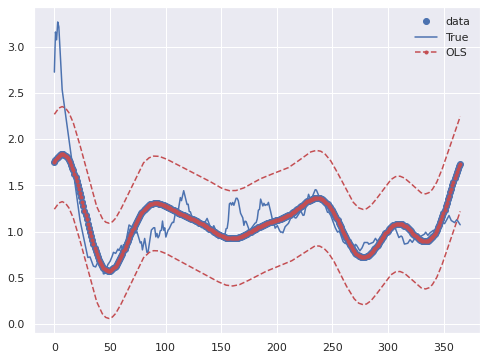

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     335.7
Date:                Sat, 17 Apr 2021   Prob (F-statistic):          3.70e-243
Time:                        19:32:39   Log-Likelihood:                 563.12
No. Observations:                 365   AIC:                            -1028.
Df Residuals:                     316   BIC:                            -837.1
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
NU

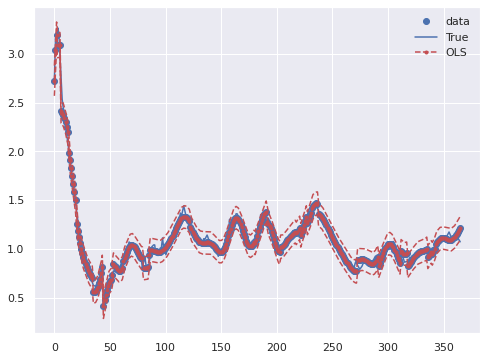

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              3192.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:32:39   Log-Likelihood:                          527.41
No. Observations:                 365   AIC:                                     -970.8
Df Residuals:                     323   BIC:                                     -807.0
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

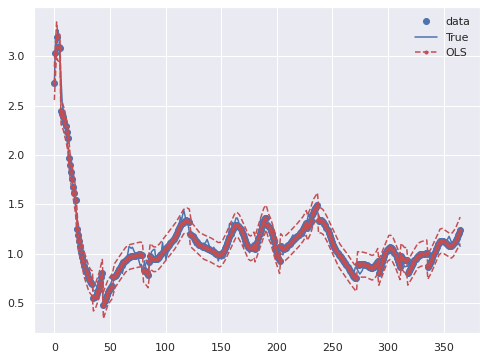

In [12]:
# Find best weather features
select_k = 12
#mutual_info_regression, f_regression
selector = SelectKBest(score_func=f_regression, k=select_k)
scaler = MinMaxScaler()
X_w = pd.DataFrame(scaler.fit_transform(X_w), columns=X_w.columns)
X_best = selector.fit_transform(X_w, y)
mask = selector.get_support() #list of booleans
features = [] # The list of your K best features
for bool, feature in zip(mask, X_w.columns):
    if bool:
        features.append(feature)
print('\nSelected k Reg. Features:', features)
X_w_best = X_w[features]

mod = sm.OLS(y, X_w_best)
res = mod.fit()
print(res.summary())

x = np.linspace(0,365,365)

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X_w_best)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()

# Try to build a good regressor
X = X_w_best#calculate_vif_(X_w_best, 5)

# Feature Engineering
# https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
import scipy.stats as st
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
for col in X.columns:
    X["{}_log+1".format(col)] = (X[col]+1).transform(np.log) # Log transform
    X["{}_conv".format(col)] = np.convolve(X[col], kern1d, 'same') # Convolution
    X["{}_pow2".format(col)] = X[col]*X[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g = pd.DataFrame(scaler.fit_transform(X_g), columns=X_g.columns)
X = pd.concat((X, X_g), axis=1)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()



# Remove statistically insignificant (p 0.05) features, they could break the model
insignificant = ['Stringency_index', 
                 'Information_campaigns', 
                 'REL_HUM', 
                 'SUN_H_conv', 
                 'NUM_WIND_VEL60_log+1',
                 'NUM_ICE_conv',
                 'NUM_CLEAR_log+1',
                 'NUM_PRECP_01_log+1',
                 'P_MAX',
                 'NUM_WIND_VEL60_conv',
                 'REL_HUM_MIN_log+1',
                 'REL_HUM_conv',
                 'NUM_CLOUD',
                 'NUM_PRECP_01_conv',
                 'PRECP_SUM',
                 'PRECP_SUM_conv',
                 'NUM_FROST',
                 'P_MAX_conv'
                ]


X = X.drop(columns=insignificant)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_const_cols = X.columns[X.nunique() <= 1]
#for col in X.columns:
#    if col not in X_const_cols:
        #X[col] = X[col]*X[col]+1
        #X[col], _, = boxcox(X[col], lmbda=None, alpha=None)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()


mod_lwr = sm.OLS(y_lwr, X)
res_lwr = mod.fit()
#print('\n Selected Featres OLS for R_eff_lwr')
#print(res_lwr.summary())

mod = sm.OLS(y_upr, X)
res_upr = mod.fit()
#print('\n Selected Featres OLS for R_eff_upr')
#print(res_upr.summary())


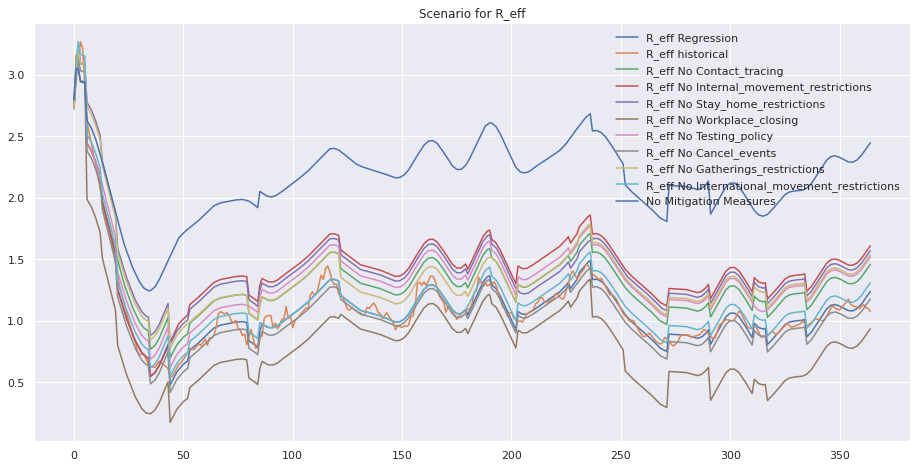

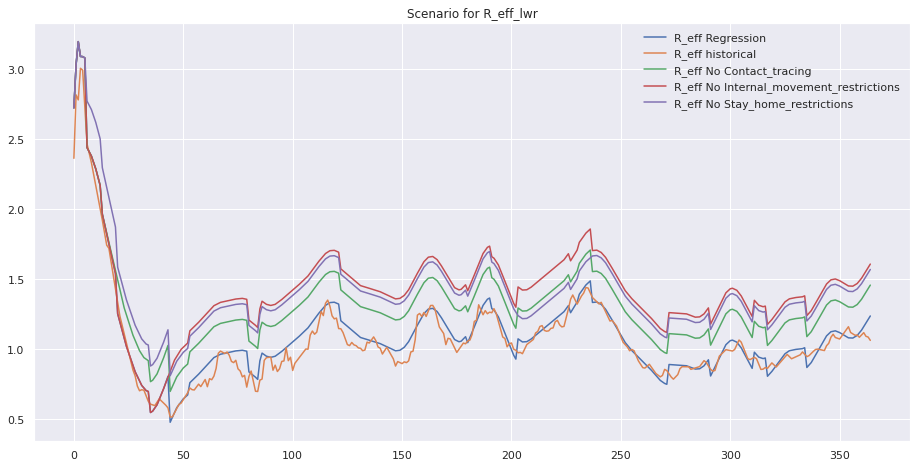

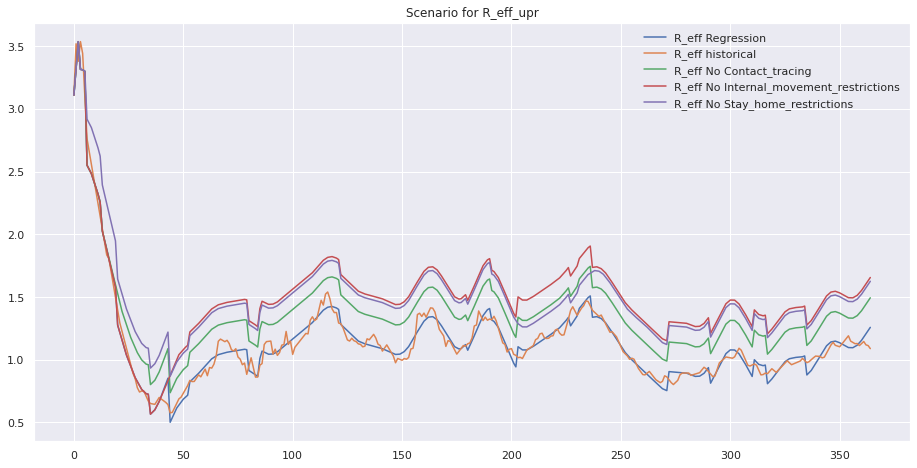

In [13]:
# Still some multicolinearity but we need some restriction still in the dataset
# Let's test the model an see how it behaves:
#plt.plot(res.predict(X), label ='R_eff Regression')
#plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.title('Scenario for R_eff')
#plt.legend()
#plt.show()

plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()

plt.plot(res_lwr.predict(X), label ='R_eff Regression')
plt.plot(y_lwr, label = 'R_eff historical')
plt.plot(res_lwr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_lwr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_lwr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_lwr')
plt.legend()
plt.show()

plt.plot(res_upr.predict(X), label ='R_eff Regression')
plt.plot(y_upr, label = 'R_eff historical')
plt.plot(res_upr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_upr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_upr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_upr')
plt.legend()
plt.show()

0.9597309376270917


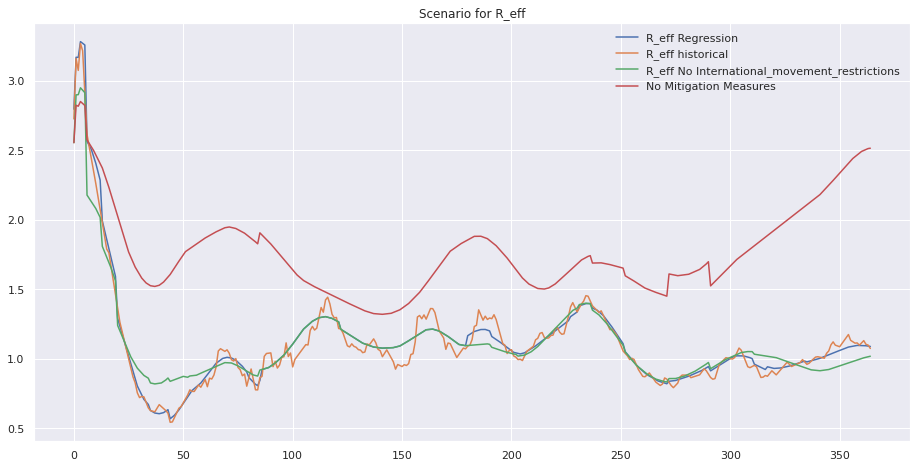

0.9641407136588281
0.9572018034965825


In [240]:
# Give MLP Regressor a shot
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, random_state=1, test_size=0.3)

res = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1,
                   batch_size=10, warm_start= False
                  ).fit(X_train, y_train)
print(res.score(X_test, y_test))



plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
#plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
#plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
#plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()


#Lets look at lowr and upr bounds
X_train, X_test, y_train, y_test = train_test_split(X, y_lwr, random_state=1, test_size=0.3)
res_lwr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_lwr.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y_upr, random_state=1, test_size=0.3)
res_upr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_upr.score(X_test, y_test))

## SEIR-FV Model with Reinfection, ICUs and Hospitalizations Capacities, Adjusted for Age-Groups and Virus Reproduction depending on Meteorological Effects and Government Policies
Improved SIR Model taking into account weather and effective reproduction number based on various mitigation scenarios

In [867]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
#ICUs_free = 1072 # Mar 27 2020
#HOSPs_free = 21682 # Mar 27 2020

ICUs_free = aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree']
ICUs_free = sum(ICUs_free)/len(ICUs_free
                              )
HOSPs_free = aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree']
HOSPs_free = sum(HOSPs_free)/len(HOSPs_free)

VAC_full_effect = 0.9 #Probability of any vaccine preventing contraction, cannot infect others
VAC_once_effect = 0.9 #Probability of any vaccine preventing death, can infect others

def deriv(t, y, N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R_eff):
    ICUs_required = 0
    HOSPs_requried = 0
    N_sum = sum(N)
    numvars = 7
    
    #Compute ICUs and Hospital Beds required
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        ICUs_required+=I*epsilon[i//numvars]*rho[i//numvars]
        HOSPs_requried+=I*epsilon[i//numvars]*rho[i//numvars]
    HOSPs_requried - ICUs_required
    
    # Hospital beds or ICUs full
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)

    #Time until Exposed move to Infected
    alpha = 1.0/3.0 # https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile
    
    # Intra group contractions
    beta = [R_eff[int(round(t))]*(gamma[i]+delta_i) for i, delta_i in enumerate(delta)]
    
    # Inter group contractions
    beta_avg = sum(beta)/len(beta)
    beta = [0.5*(beta_avg+b) for b in beta]

    vacs_once_available = vac_once_per_day
    vacs_full_available = vac_full_per_day
    y_inv = y[::-1] # Invert for age prefering vaccinations
    y_i = ()
    for j in range(0,len(y_inv),numvars):
        S, E, I, R, F, V1, V2 = y_inv[j:j+numvars][::-1]
        i = len(y_inv)-numvars - j

        # Single and Double Vaccinations
        # Old First
        dV2dt = vacs_full_available if S > vacs_full_available else np.abs(vacs_full_available - S)
        if (dV2dt+V2) > (S+R+I+E+V1) or t < t_vac_full_start: # Sanity, can never vaccinated more than living gorup
            dV2dt = +0.0
        vacs_full_available = np.abs(vacs_full_available - dV2dt)
        
        dV1dt = vacs_once_available if S > vacs_once_available else np.abs(vacs_once_available - S)
        if (dV1dt+V1) > (S+R+I+E+V2) or t < t_vac_once_start: # Sanity, can never vaccinated more than living gorup
            dV1dt = +0.0
        vacs_once_available = np.abs(vacs_once_available - dV1dt)
        
        # Random
        #dV1dt = S * vac_once_per_day/N_sum*VAC_once_effect if t >= t_vac_once_start else 0
        #dV2dt = S * vac_full_per_day/N_sum*VAC_full_effect if t >= t_vac_full_start else 0
        
        
        # Decrease in Suspectables
        dSdt = -beta[i//numvars] * S * I / N[i//numvars] - dV2dt if S >= 0 else +0.0
            
        # Probability that and individual of a group has been succesfully vaccinated once
        theta = max(min(V1/S,1.0),0)
        
        # Suspectable to Exposed minus Exposed to Infected
        dEdt = beta[i//numvars] * S * I / N[i//numvars] - alpha * E
        
        # Infected to Recovered
        dRdt = (1+theta)* I * gamma[i//numvars] * (1 - (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Infected to Fatalities
        dFdt = (1-theta)* I * delta[i//numvars] * (1 + (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Exposed to Infected minus Recovered + Fatalities
        dIdt = alpha * E - dRdt - dFdt
        
        # Reinfection after reocivering possible after 5-7 months: 
        # EXPERIMENTAL
        # https://www.cell.com/immunity/fulltext/S1074-7613(20)30445-3
        # How ist it with Vaccines?
        dSdt += (1.0/180.0)*R + (1.0/210.0)*V2
        dV2dt += -(1.0/210.0)*V2
        dV1dt += -(1.0/210.0)*V1
        dRdt += -(1.0/180.0)*R
        
        y_i += dV2dt, dV1dt, dFdt, dRdt, dIdt, dEdt, dSdt
    return y_i[::-1]

from scipy.integrate import solve_ivp
def run_sim(N, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, t_vac_once_start, t_vac_full_start, R):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - E0- I0 - R0 - F0 - V20
        y0 += (S0, E0, I0, R0, F0, V10, V20)

    ret = solve_ivp(fun=deriv, t_span=(min(t), max(t)), y0=y0, t_eval=t, first_step = 0.01, max_step=0.25,
                    method='RK23', rtol=1e-3, atol=1e-6,
                    args=(N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R))
    return [*ret['y']]

## NN Corrected SIR

SCENARIO: PREDICTED R, HISTORICAL MEASURES
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.048717711640306464
['5-14'] 0.05232787588997532
['15-24'] 0.05281692457523062
['25-34'] 0.05365679823083969
['35-44'] 0.0535542787026375
['45-54'] 0.053922775527808386
['55-64'] 0.0535326759677041
['65-74'] 0.10243942705645133
['75-84'] 0.29655339818519755
['>84'] 0.23247813422384903
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, HISTORICAL MEASURES
Infected: 413890 453221 492552
Fatal: 7963 8739 9946
Peak Hospitalization Requirements: 3364 3723 4109
Peak ICU Requirements: 694 719 793
[0.00000000e+00 4.85682885e-05 1.49540039e-04 2.44054899e-04
 6.41020275e-04 2.75870630e-03 1.34033617e-02 6.36156974e-02
 8.90322165e-02 1.69875167e-01]


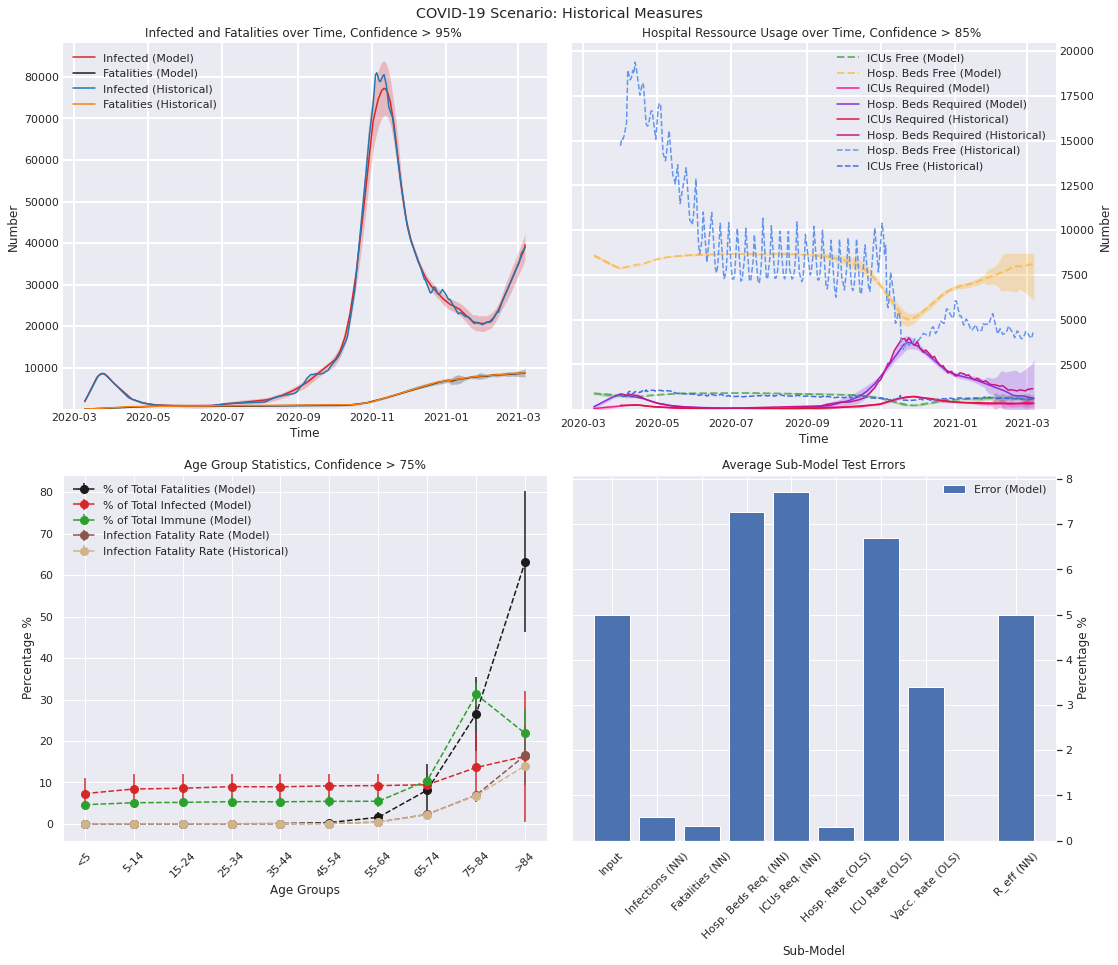

SCENARIO: PREDICTED R, NO EVENTS CANCELED
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.05008334165219266
['5-14'] 0.05433807756613961
['15-24'] 0.0549320098950651
['25-34'] 0.0559729315458157
['35-44'] 0.05584786394004328
['45-54'] 0.05633947864044229
['55-64'] 0.05596634898380218
['65-74'] 0.0991020485451528
['75-84'] 0.28838893262191195
['>84'] 0.2290289666094345
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO EVENTS CANCELED
Infected: 315076 394926 474777
Fatal: 7535 10902 14485
Peak Hospitalization Requirements: 2762 3296 4840
Peak ICU Requirements: 211 674 3890
[0.00000000e+00 3.18974013e-05 9.79147464e-05 1.58424725e-04
 4.16577004e-04 1.78029085e-03 8.64445999e-03 4.12347843e-02
 7.18607984e-02 1.24224909e-01]


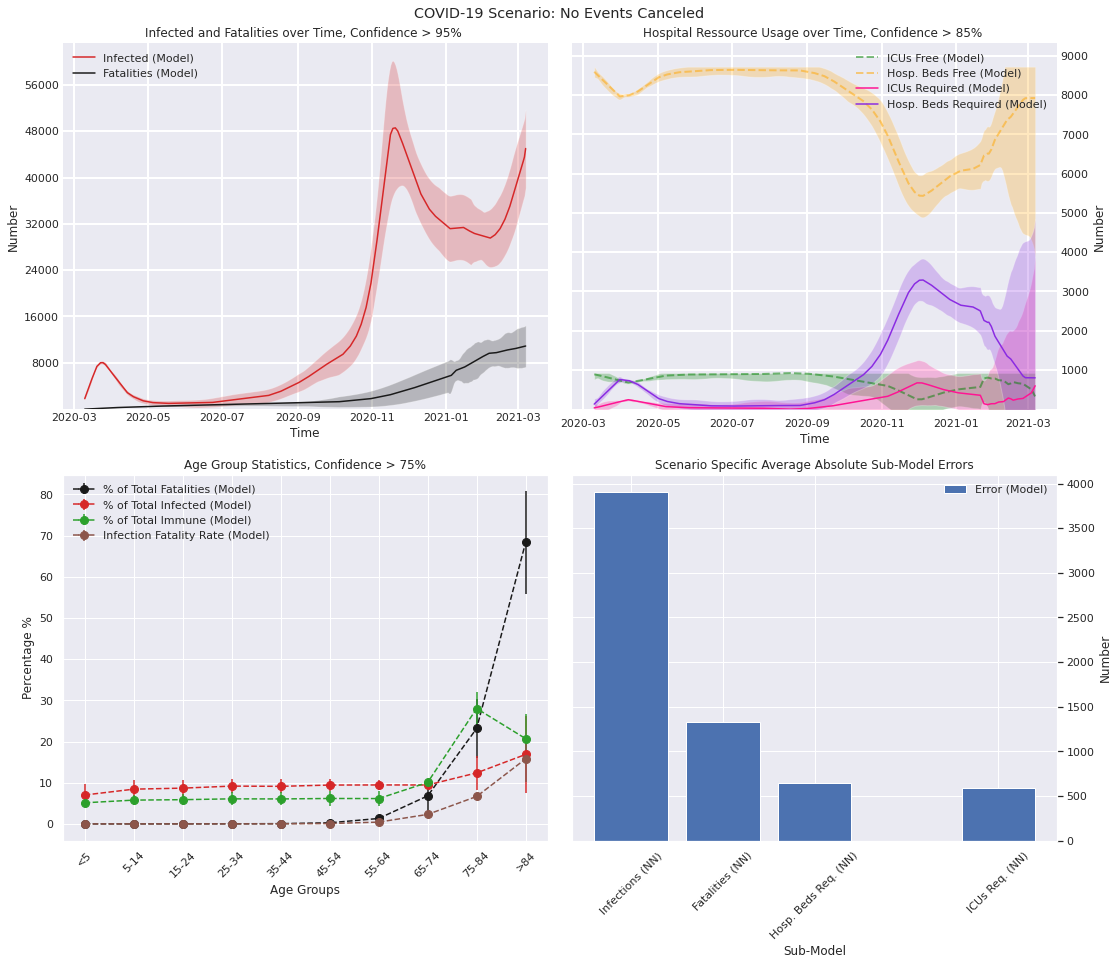

SCENARIO: PREDICTED R, NO CONTACT TRACING
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.05363988930994608
['5-14'] 0.07247262068911645
['15-24'] 0.07654134715924256
['25-34'] 0.08547600476832759
['35-44'] 0.08442179960990293
['45-54'] 0.09065567529451674
['55-64'] 0.09172414760546468
['65-74'] 0.11521469856202084
['75-84'] 0.2349934614089321
['>84'] 0.09486035559252992
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO CONTACT TRACING
Infected: 1057467 1995617 2933766
Fatal: 4272 33874 73973
Peak Hospitalization Requirements: 6894 14809 29374
Peak ICU Requirements: 262 2417 21681
[0.00000000e+00 7.99207753e-06 2.88253600e-05 6.42278540e-05
 1.62523328e-04 8.33625946e-04 3.81926995e-03 1.30116433e-02
 3.11570650e-02 4.81543839e-02]


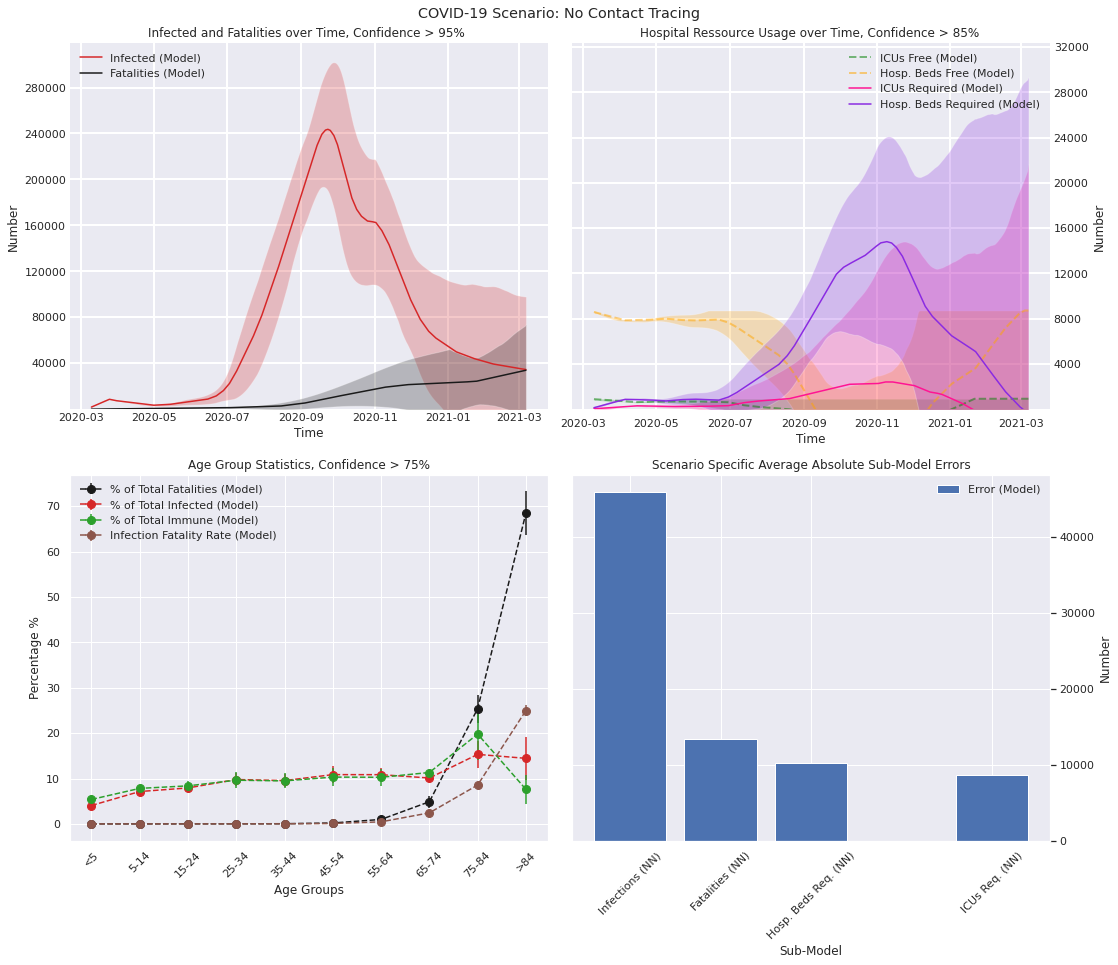

SCENARIO: PREDICTED R, NO INTERNAL RESTRICTIONS
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.054940145914473944
['5-14'] 0.06214537036041897
['15-24'] 0.06322762206536255
['25-34'] 0.06518620701701217
['35-44'] 0.06495544366053245
['45-54'] 0.06596303445719222
['55-64'] 0.06551243889362676
['65-74'] 0.09658376971842157
['75-84'] 0.2550682279452614
['>84'] 0.20641773996769763
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO INTERNAL RESTRICTIONS
Infected: 545422 691777 838132
Fatal: 7779 15239 22735
Peak Hospitalization Requirements: 4113 5364 6645
Peak ICU Requirements: 235 1241 4986
[0.00000000e+00 3.25023186e-05 9.98208173e-05 1.61094413e-04
 4.23767696e-04 1.80202898e-03 8.70694159e-03 3.98792849e-02
 4.40101899e-02 9.19716809e-02]


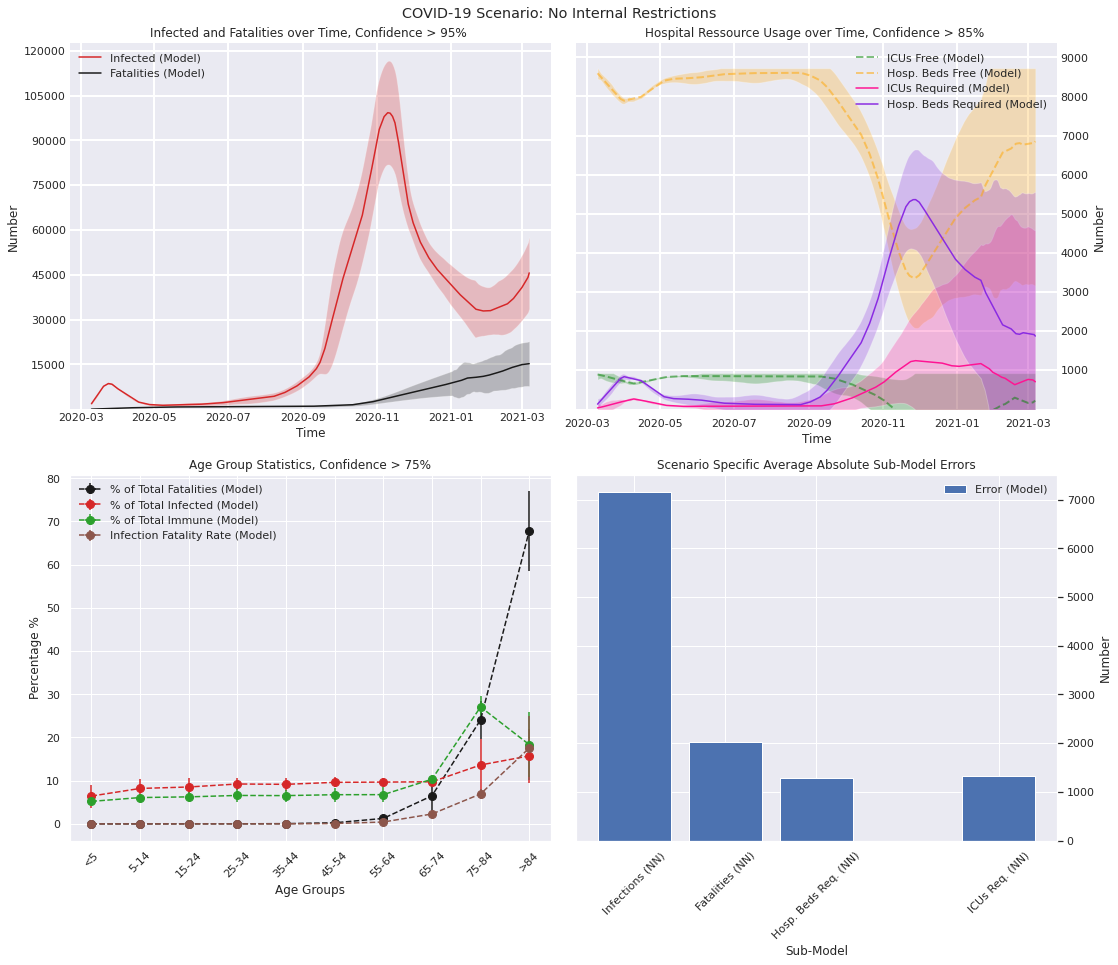

SCENARIO: PREDICTED R, NO WORKPLACE CLOSING
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.0470023452980779
['5-14'] 0.050258149881284055
['15-24'] 0.05069650388963813
['25-34'] 0.05144767661481132
['35-44'] 0.05135549383542229
['45-54'] 0.05168108369123144
['55-64'] 0.05131589283074359
['65-74'] 0.10249438552276331
['75-84'] 0.3045118261981012
['>84'] 0.23923664223792687
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO WORKPLACE CLOSING
Infected: 345479 407346 469213
Fatal: 7381 8950 10998
Peak Hospitalization Requirements: 2559 3066 3736
Peak ICU Requirements: 232 591 2677
[0.00000000e+00 5.16869884e-05 1.59480122e-04 2.61274249e-04
 6.85953020e-04 2.95830845e-03 1.43686716e-02 6.75000992e-02
 9.58772756e-02 1.81799652e-01]


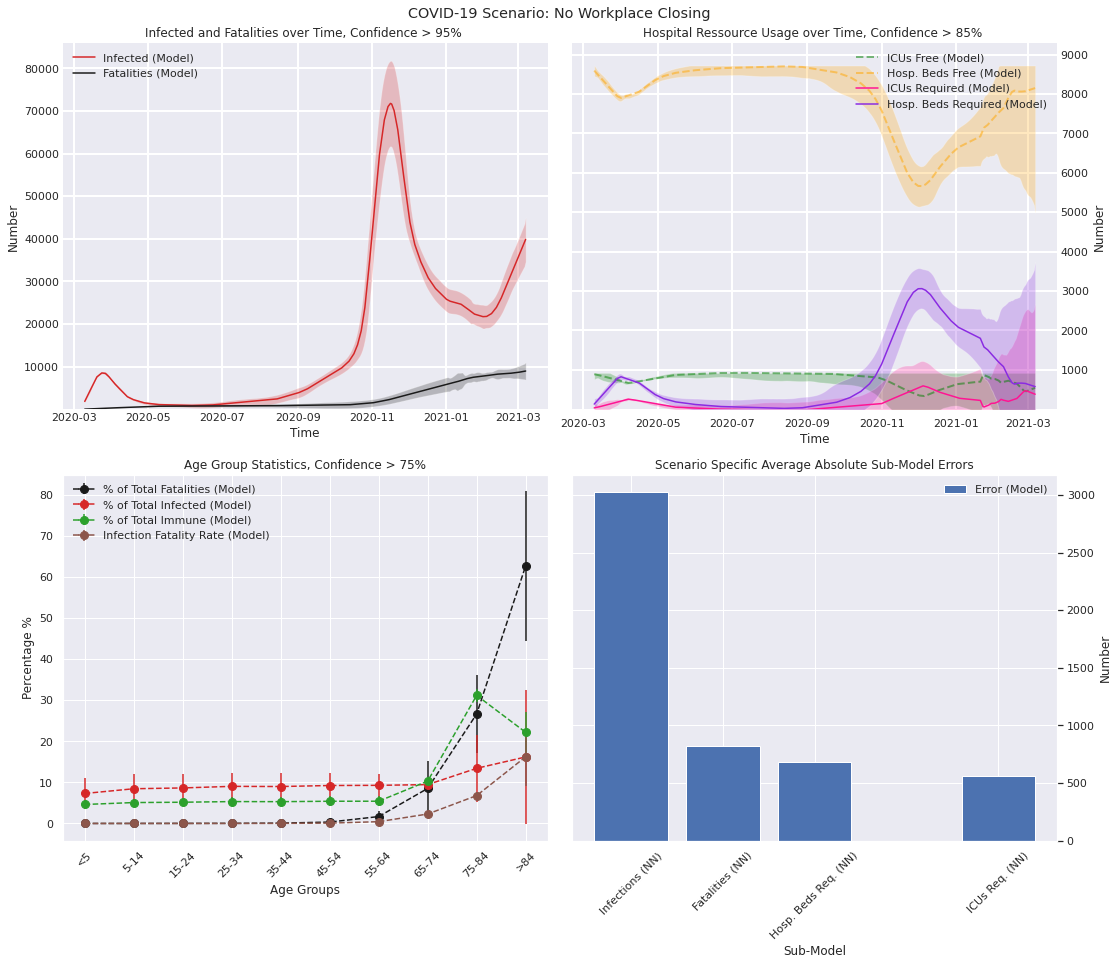

SCENARIO: PREDICTED R, NO STAY HOME RESTRICTIONS
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.05052866299715557
['5-14'] 0.059438581652757415
['15-24'] 0.06114494627035888
['25-34'] 0.06475257957065653
['35-44'] 0.06434588679695344
['45-54'] 0.0668794513036425
['55-64'] 0.06774765122129253
['65-74'] 0.10170379570121782
['75-84'] 0.29367278259864005
['>84'] 0.16978566188732563
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO STAY HOME RESTRICTIONS
Infected: 150900 485760 820620
Fatal: 666 12783 34676
Peak Hospitalization Requirements: 1062 5495 14081
Peak ICU Requirements: 267 2768 12695
[0.00000000e+00 4.10173205e-05 1.26686769e-04 2.07358911e-04
 5.44514317e-04 2.34174055e-03 1.13467896e-02 5.28529046e-02
 7.08222184e-02 1.36277888e-01]


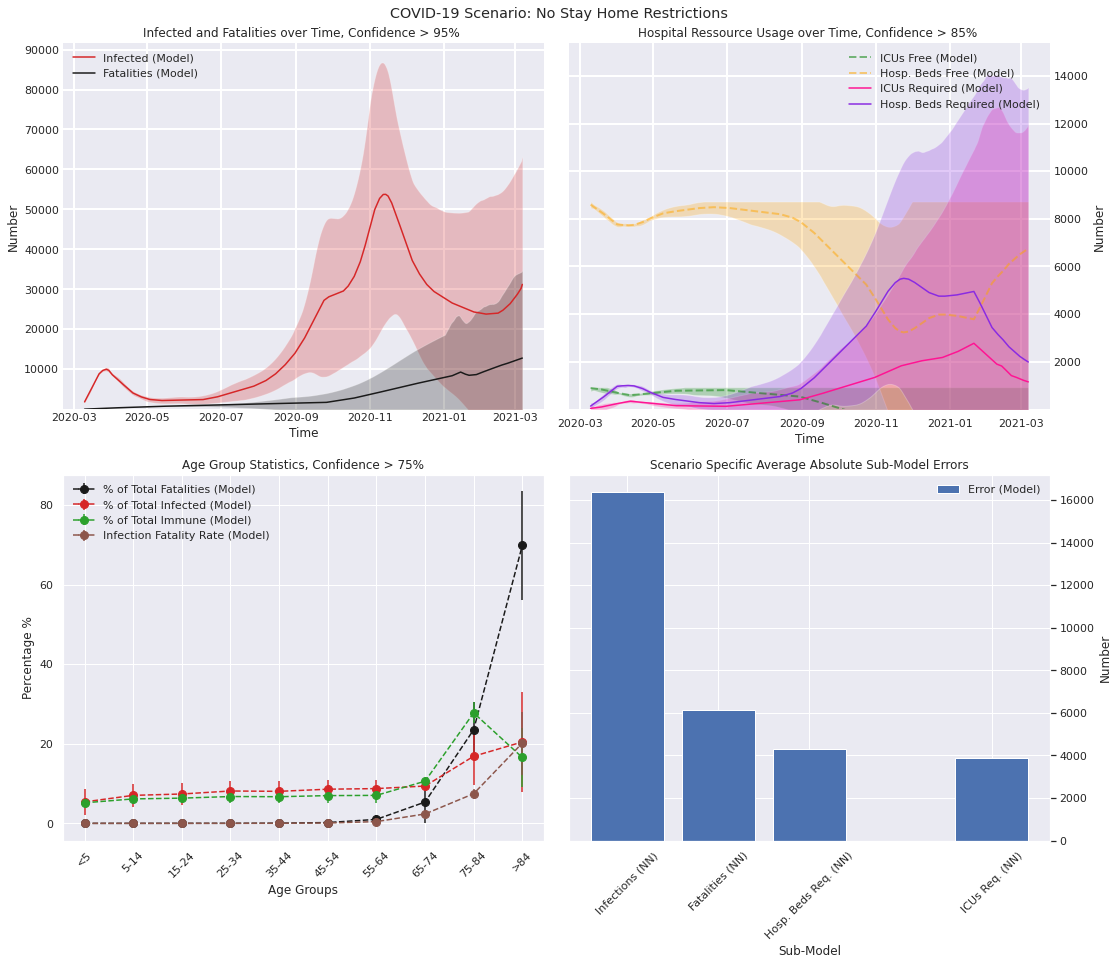

SCENARIO: PREDICTED R, NO GATHERING RESTRICTIONS
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.05134141812586639
['5-14'] 0.06067111332637779
['15-24'] 0.06244984750517214
['25-34'] 0.06619489792044644
['35-44'] 0.06577126816570565
['45-54'] 0.06837656825359571
['55-64'] 0.06920053432527588
['65-74'] 0.10155794440902081
['75-84'] 0.28714127070395373
['>84'] 0.16729513726458575
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO GATHERING RESTRICTIONS
Infected: 209260 545650 882040
Fatal: 4246 17368 36074
Peak Hospitalization Requirements: 2344 5815 9292
Peak ICU Requirements: 325 1551 6748
[0.00000000e+00 4.74970507e-06 1.68207879e-05 3.61843266e-05
 9.21844308e-05 4.71915520e-04 2.35269118e-03 1.14167065e-02
 5.45724156e-02 6.88116437e-02]


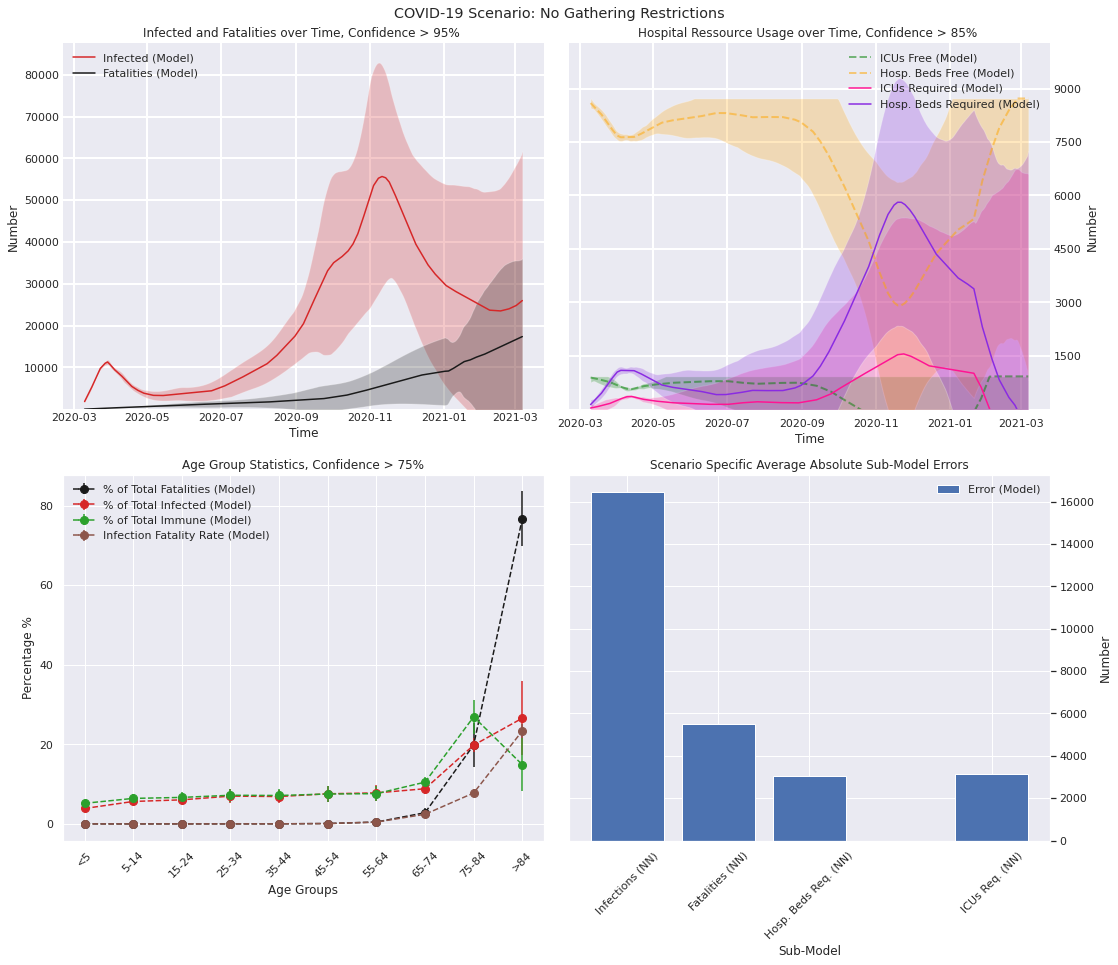

SCENARIO: PREDICTED R, NO SCHOOL CLOSINGS
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.051971132389344234
['5-14'] 0.0638213388160203
['15-24'] 0.06619371701778226
['25-34'] 0.07128258785389116
['35-44'] 0.07070229090910782
['45-54'] 0.07429130158317483
['55-64'] 0.07539521065806865
['65-74'] 0.10729553444381189
['75-84'] 0.27757000125443065
['>84'] 0.14147688507436817
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO SCHOOL CLOSINGS
Infected: 154829 620848 1086867
Fatal: 880 15760 43194
Peak Hospitalization Requirements: 1630 7125 13375
Peak ICU Requirements: 311 2434 13338
[0.00000000e+00 5.44233109e-06 1.91823848e-05 4.09228811e-05
 1.04330451e-04 5.31120673e-04 2.63545744e-03 1.26578689e-02
 6.17154160e-02 7.74625427e-02]


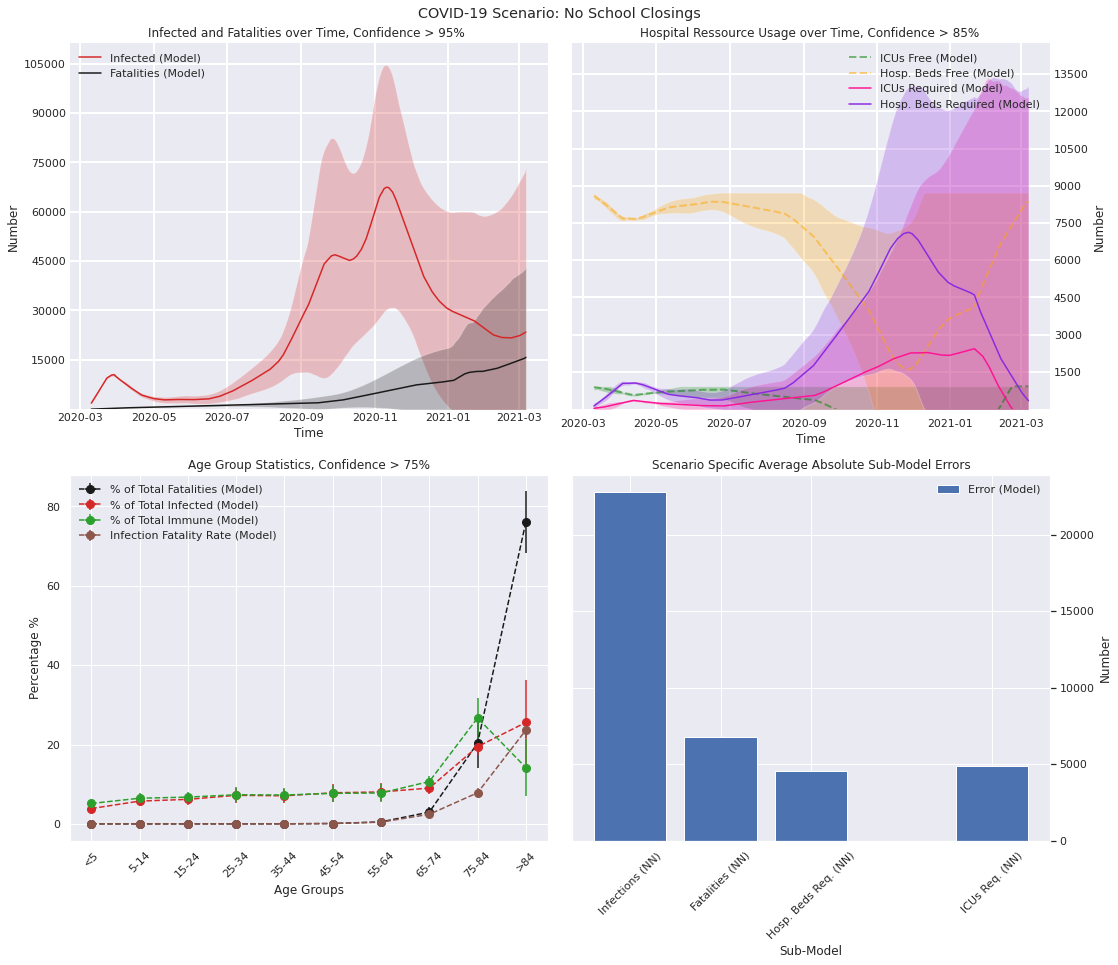

SCENARIO: PREDICTED R, NO MITIGATION MEASURES
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.05172694383956382
['5-14'] 0.09238899736731258
['15-24'] 0.10289332896346914
['25-34'] 0.12737415751188647
['35-44'] 0.12411605101661165
['45-54'] 0.13984749916700573
['55-64'] 0.1334104501016503
['65-74'] 0.10347325479007165
['75-84'] 0.10047621723706403
['>84'] 0.024293100005364766
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, NO MITIGATION MEASURES
Infected: 1307988 3543713 5779438
Fatal: 79783 91424 141038
Peak Hospitalization Requirements: 20226 37995 58107
Peak ICU Requirements: 168 11422 42733
[0.00000000e+00 3.60113009e-06 1.20664587e-05 2.36118756e-05
 6.06409125e-05 2.92258106e-04 1.38303706e-03 5.83839082e-03
 9.40250420e-03 1.70142322e-02]


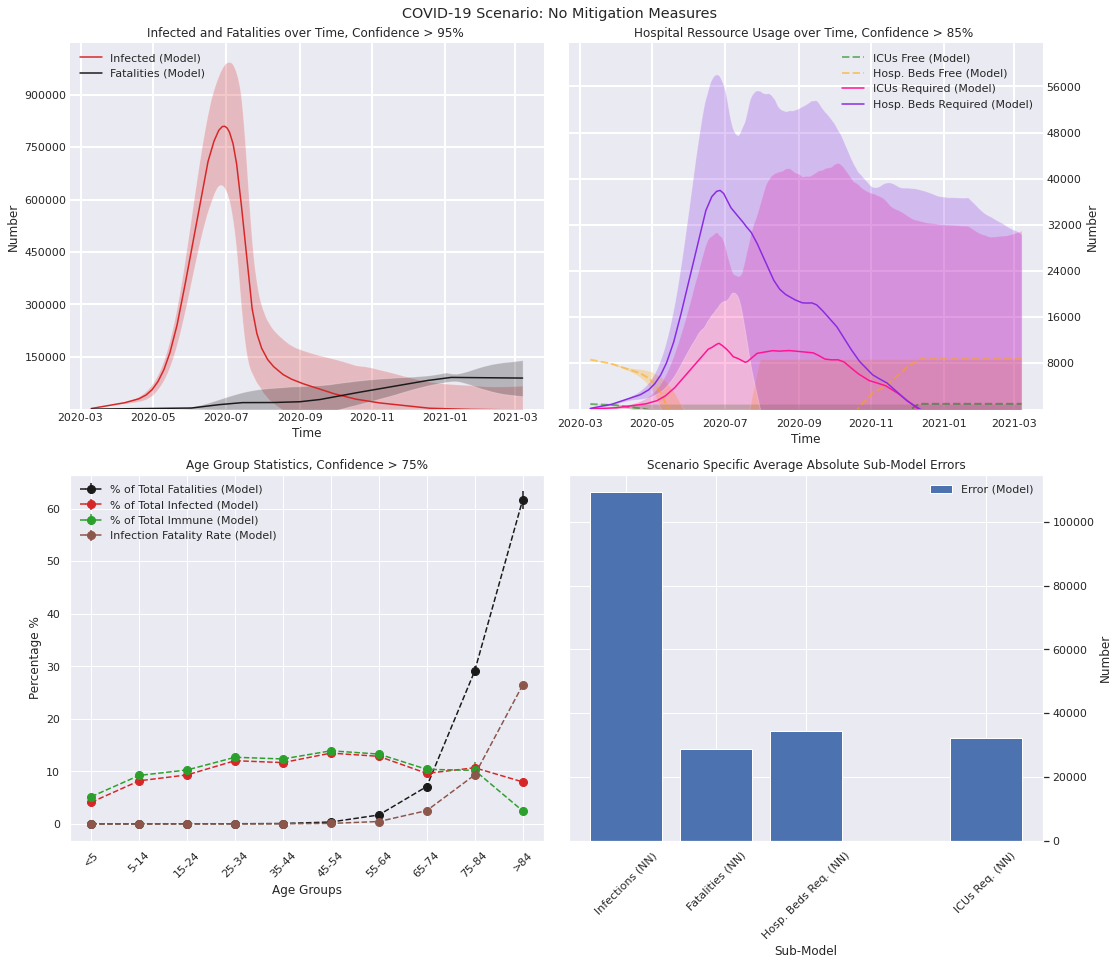

SCENARIO: PREDICTED R, ZERO-COVID MEASURES
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.013257939448249538
['5-14'] 0.013331880650991394
['15-24'] 0.013340409725827233
['25-34'] 0.013354787262574708
['35-44'] 0.013351209003837546
['45-54'] 0.013347718416370316
['55-64'] 0.013291423567089376
['65-74'] 0.10975692933185252
['75-84'] 0.44992610099353525
['>84'] 0.3470416015996725
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, ZERO-COVID MEASURES
Infected: 20827 57044 93261
Fatal: 260 6596 34185
Peak Hospitalization Requirements: 237 280 10952
Peak ICU Requirements: 60 73 12739
[0.00000000e+00 4.61917362e-06 1.44096836e-05 2.40970317e-05
 6.31176421e-05 2.75682144e-04 1.34045332e-03 5.64513303e-03
 5.09579525e-03 1.24627082e-02]


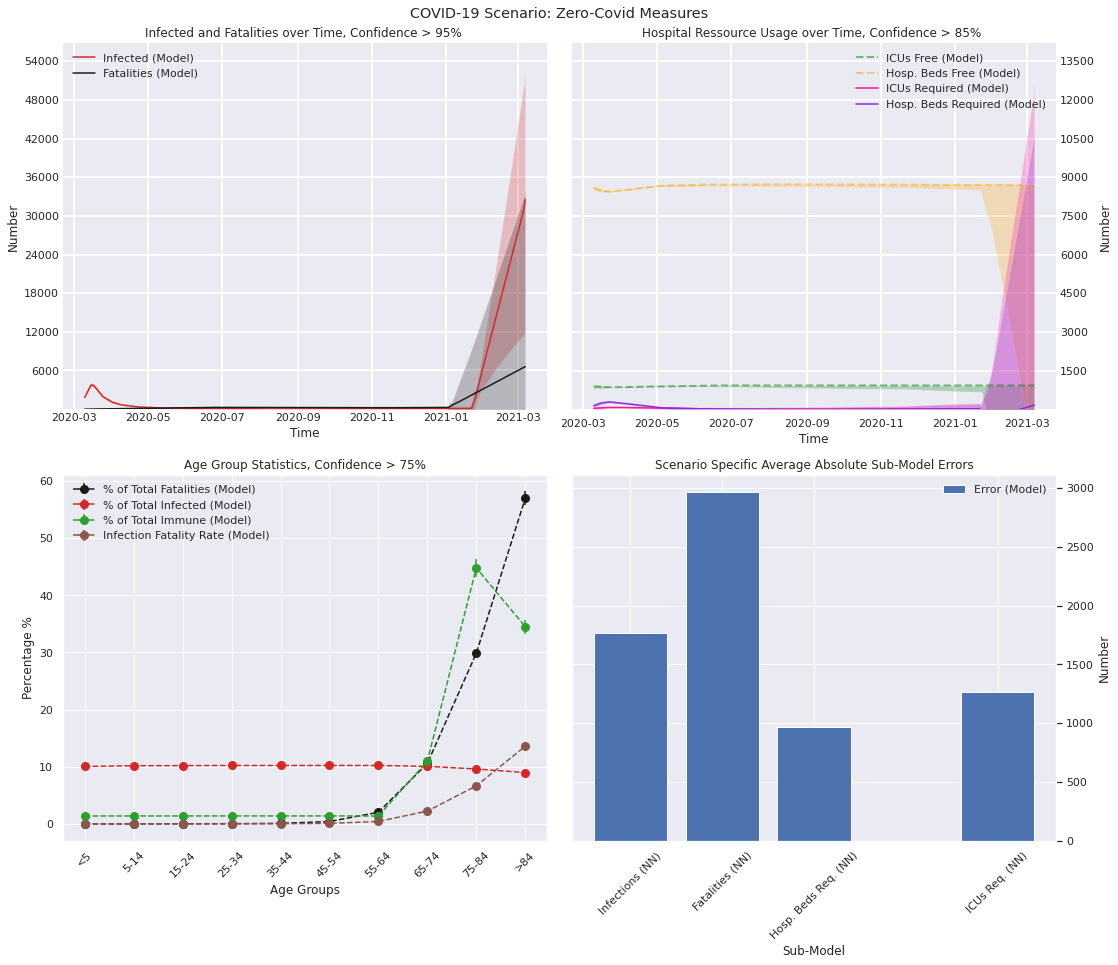

SCENARIO: PREDICTED R, ONLY CONTACT TRACING, TESTING
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.053842707697866796
['5-14'] 0.08136704538893573
['15-24'] 0.08781274053673728
['25-34'] 0.10233346440382514
['35-44'] 0.10052834111029936
['45-54'] 0.11033644881470848
['55-64'] 0.10967090092841873
['65-74'] 0.11528009854973499
['75-84'] 0.17785675510097346
['>84'] 0.06097149746850024
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, ONLY CONTACT TRACING, TESTING
Infected: 332850 1488441 2644032
Fatal: 8633 37660 76891
Peak Hospitalization Requirements: 3901 10880 24045
Peak ICU Requirements: 158 4214 20037
[0.00000000e+00 3.75644362e-06 1.39030916e-05 3.23424646e-05
 8.12912884e-05 4.20125011e-04 1.79585965e-03 5.58266528e-03
 2.02660344e-02 2.75803726e-02]


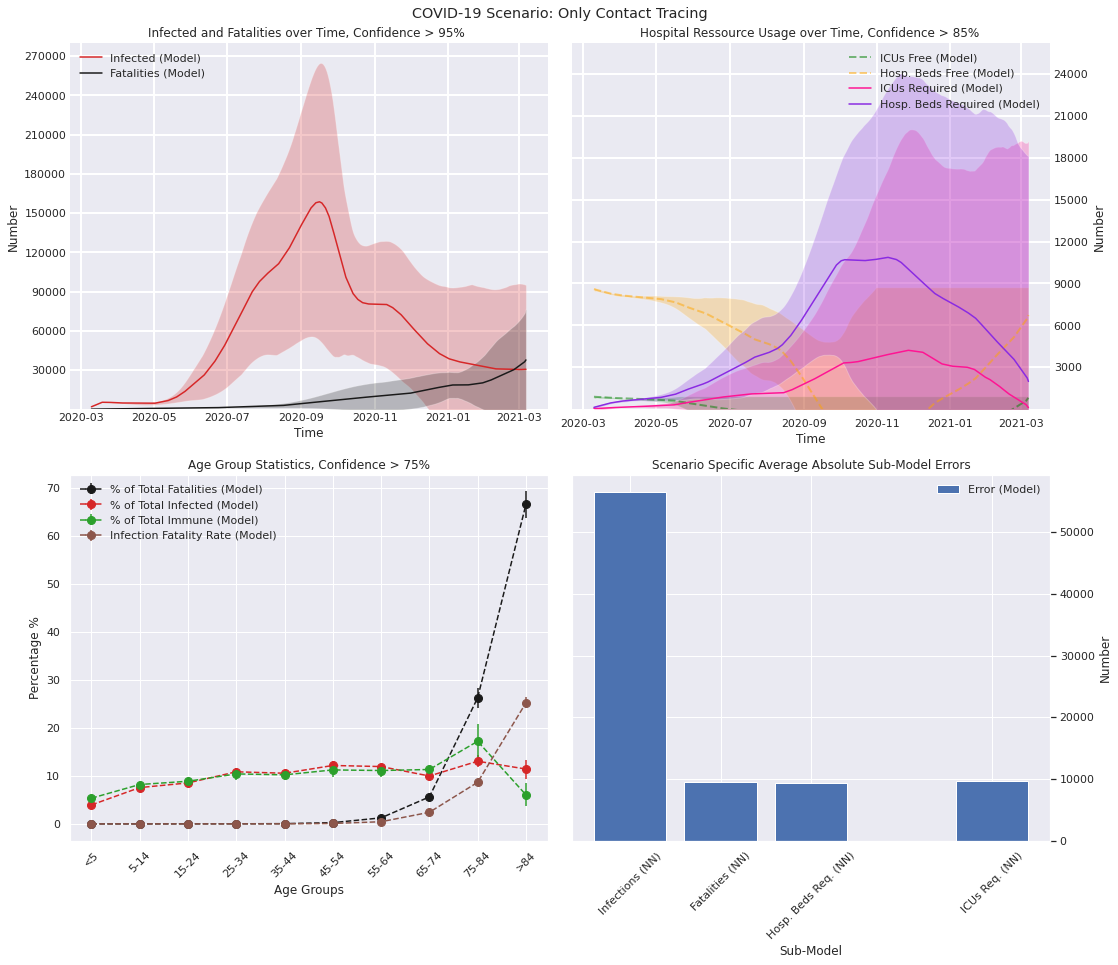

SCENARIO: PREDICTED R, ONLY CONTACT TRACING, BORDER CLOSURES, EVENTS, TESTING
Progress: 0.0%
[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
['<5'] 0.0518921740515413
['5-14'] 0.08474711186041943
['15-24'] 0.09289134400147481
['25-34'] 0.11166002588745044
['35-44'] 0.10926086180332306
['45-54'] 0.12186686167458266
['55-64'] 0.11965801776343644
['65-74'] 0.11422467049196137
['75-84'] 0.1511487061455984
['>84'] 0.04265022632021213
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, ONLY CONTACT TRACING, BORDER CLOSURES, EVENTS, TESTING
Infected: 179080 1387261 2595441
Fatal: 28806 70226 119377
Peak Hospitalization Requirements: 2992 11040 28596
Peak ICU Requirements: 218 4285 22661
[0.00000000e+00 2.73707128e-06 9.89075271e-06 2.20204225e-05
 5.55939025e-05 2.79553565e-04 1.18576342e-03 3.98493399e-03
 6.06887749e-03 1.11406363e-02]


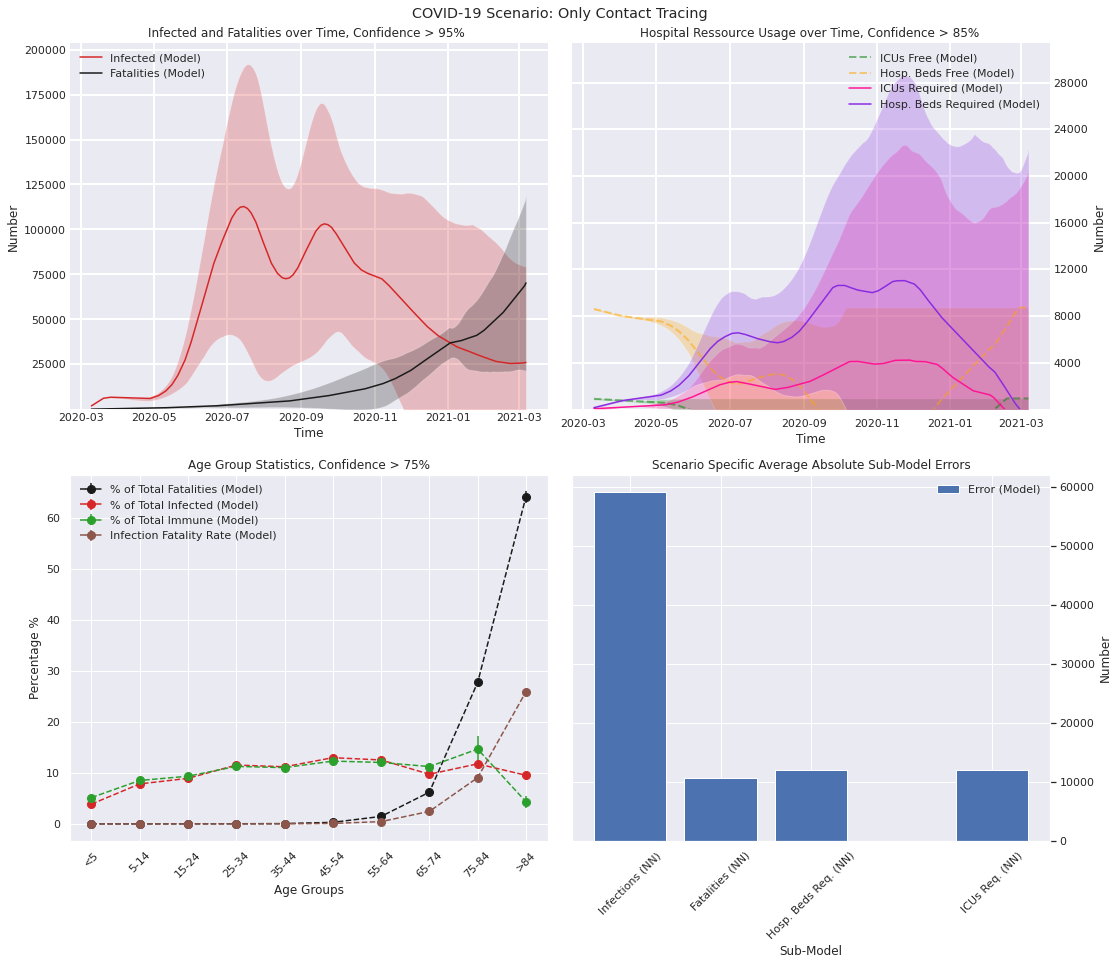

In [982]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_full_start = 317 #Full vaccinations 15.01.2021
t_vac_once_start = 298 #Full vaccinations 27.12.2020
duration = 363#len(aut_cov['Infected'].to_numpy())

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }


scenarios = {
    #'Historical R, Historical Measures' : [y_lwr, y, y_upr, scores],
    #
    'Predicted R, Historical Measures' : [res_lwr.predict(X), res.predict(X), res_upr.predict(X), scores],

    'Predicted R, No Events Canceled' :[res_lwr.predict(X.assign(Cancel_events = 0)),
                           res.predict(X.assign(Cancel_events = 0)),
                           res_upr.predict(X.assign(Cancel_events = 0)), None],
    'Predicted R, No Contact Tracing' :[res_lwr.predict(X.assign(Contact_tracing = 0)),
                           res.predict(X.assign(Contact_tracing = 0)),
                           res_upr.predict(X.assign(Contact_tracing = 0)), None],


    'Predicted R, No Internal Restrictions' :[res_lwr.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res_upr.predict(X.assign(Internal_movement_restrictions = 0)), None],
    'Predicted R, No Workplace Closing' :[res_lwr.predict(X.assign(Workplace_closing = 0)),
                                      res.predict(X.assign(Workplace_closing = 0)),
                                      res_upr.predict(X.assign(Workplace_closing = 0)), None],

    'Predicted R, No Stay Home Restrictions' :[res_lwr.predict(X.assign(Stay_home_restrictions = 0)),
                                  res.predict(X.assign(Stay_home_restrictions = 0)),
                                  res_upr.predict(X.assign(Stay_home_restrictions = 0)), None],
    'Predicted R, No Gathering Restrictions' :[res_lwr.predict(X.assign(Gatherings_restrictions = 0)),
                                  res.predict(X.assign(Gatherings_restrictions = 0)),
                                  res_upr.predict(X.assign(Gatherings_restrictions = 0)), None],
    'Predicted R, No School Closings': [res_lwr.predict(X.assign(School_closing = 0)),
                                  res.predict(X.assign(School_closing = 0)),
                                  res_upr.predict(X.assign(School_closing = 0)), None],
    'Predicted R, No Mitigation Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0,
                                                      Transport_closing = 0)),
                                res.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0,
                                                      Transport_closing = 0)),
                                res_upr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0,
                                                      Transport_closing = 0)), None],
    'Predicted R, Zero-Covid Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1,
                                                      Transport_closing = 1)),
                                res.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1,
                                                      Transport_closing = 1)),
                                res_upr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1,
                                                      Transport_closing = 1)), None],
    'Predicted R, Only Contact Tracing, Testing' : [res_lwr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)),
                                res.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)),
                                res_upr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)), None],
    'Predicted R, Only Contact Tracing, Border Closures, Events, Testing' : [res_lwr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)),
                                res.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)),
                                res_upr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 1,
                                                      School_closing = 0)), None],
        
}

def is_fitted(model):
   # Source: https://stackoverflow.com/questions/39884009/whats-the-best-way-to-test-whether-an-sklearn-model-has-been-fitted/51200847
    attrs = [v for v in vars(model)
             if v.endswith("_") and not v.startswith("__")]
    
    return len(attrs) != 0


fitted =  True
topo = (365, 365, 365, 365)
max_iter=2500
num_models = 10
if fitted == False:
    res_infs = []
    res_fats = []
    res_hosps = []
    res_icus = []
    res_infs_r2 = []
    res_fats_r2 = []
    res_hosps_r2 = []
    res_icus_r2 = []
    for i in range(0,num_models):
        res_infs.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-4, shuffle=True,
                               tol=1e-9, early_stopping=True, validation_fraction=0.1,
                               batch_size=10, warm_start= False, random_state = i
                              ))
        res_fats.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-4, shuffle=True,
                               tol=1e-9, early_stopping=True, validation_fraction=0.1,
                               batch_size=10, warm_start= False, random_state = i
                              ))
        res_hosps.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-4, shuffle=True,
                               tol=1e-9, early_stopping=True, validation_fraction=0.1,
                               batch_size=10, warm_start= False, random_state = i
                              ))
        res_icus.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-4, shuffle=True,
                               tol=1e-9, early_stopping=True, validation_fraction=0.1,
                               batch_size=10, warm_start= False, random_state = i
                              ))


    
for scenario in scenarios:
    progress = 0.0
    print("SCENARIO: {}".format(scenario.upper()))
    print("Progress: {}%".format(progress))
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[4]*2.4 ,infected[4] , recovered[4], fatal[4], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
        
    # Summarize Results
    for i in range(0,len(ret_upr),7):
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
        
    print([len(l) for l in [I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]])
    # Extract Age Group Statistics:
    
    pct_fat_lwr, pct_fat, pct_fat_upr = [], [], []
    pct_inf_lwr, pct_inf, pct_inf_upr = [], [], []
    pct_ifr_lwr, pct_ifr, pct_ifr_upr = [], [], []
    pct_v_lwr, pct_v, pct_v_upr = [], [], []
    for i in range(0, aut_age_groups.shape[0], 1):
        pct_fat_lwr.append(ret_lwr[i*7+4][-1]/F_lwr[-1])
        pct_fat_upr.append(ret_upr[i*7+4][-1]/F_upr[-1])
        pct_fat.append(ret[i*7+4][-1]/F[-1])
        
        pct_inf_lwr.append((sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14))
        pct_inf_upr.append((sum(ret_upr[i*7+2])/14)/(sum(I_upr)/14))
        pct_inf.append((sum(ret[i*7+2])/14)/(sum(I)/14))
        
        pct_ifr_lwr.append(ret_lwr[i*7+4][-1]/(sum(ret_lwr[i*7+2])/14))
        pct_ifr.append(ret[i*7+4][-1]/(sum(ret[i*7+2])/14))
        pct_ifr_upr.append(ret_upr[i*7+4][-1]/(sum(ret_upr[i*7+2])/14))
        
        pct_v_lwr.append(sum(ret_lwr[i*7+5]+ret_lwr[i*7+6]+ret_lwr[i*7+3])/(sum(V1_lwr)+sum(R_lwr)+sum(V2_lwr)))
        pct_v.append(sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
        pct_v_upr.append(sum(ret_upr[i*7+5]+ret_upr[i*7+6]+ret_upr[i*7+3])/(sum(V1_upr)+sum(R_upr)+sum(V2_upr)))
        
        print(aut_age_groups['Altersgruppe'].iloc[i], 
              sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
              
                                       
        #print(aut_age_groups['Altersgruppe'].iloc[i],
        #      (sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14),
        #      ret_lwr[i*7+4][-1]/F_lwr[-1])
        
        
    progress = 1.0/(num_models+1)
    print("Progress: {}%".format(progress*100))
    d_inf = np.array([I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]).T
    d_fat = np.array([F_upr, F, F_lwr, R_upr, R, R_lwr, V1_upr, V1, V1_lwr]).T

    if scenario == 'Predicted R, Historical Measures' and fitted == False: 
        from multiprocessing import Process
            
        X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(d_inf, 
                                                                            infected[13:363+13], 
                                                                            test_size=0.3)
        X_train_fat, X_test_fat, y_train_fat, y_test_fat = train_test_split(d_fat, 
                                                            fatal[13:363+13], 
                                                            test_size=0.3)
        X_train_hosp, X_test_hosp, y_train_hosp, y_test_hosp = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZHosp'].to_numpy()[:340], 
                                                            test_size=0.3)
        X_train_icu, X_test_icu, y_train_icu, y_test_icu = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZICU'].to_numpy()[:340], 
                                                            test_size=0.3)
        for i in range(0,num_models):
            res_infs[i].fit(X_train_inf, y_train_inf)
            res_infs_r2.append(res_infs[i].score(X_test_inf, y_test_inf))
            res_fats[i].fit(X_train_fat, y_train_fat)
            res_fats_r2.append(res_fats[i].score(X_test_fat, y_test_fat))
            res_hosps[i].fit(X_train_hosp, y_train_hosp)
            res_hosps_r2.append(res_hosps[i].score(X_test_hosp, y_test_hosp))
            res_icus[i].fit(X_train_icu, y_train_icu)
            res_icus_r2.append(res_icus[i].score(X_test_icu, y_test_icu))
            progress = (2.0+i)/(num_models+1)
            print("Progress: {}%".format(progress*100))
        fitted = True
    else:
        progress = 100.0
        print("Progress: {}%".format(progress))
        
    infs, fats, hosps, icus = [], [], [], []
    for i in range(0,num_models):
        if is_fitted(res_infs[i]) and fitted:
            infs.append(res_infs[i].predict(d_inf))
        if is_fitted(res_fats[i]) and fitted:
            fats.append(res_fats[i].predict(d_fat))
        if is_fitted(res_hosps[i]) and fitted:
            hosps.append(res_hosps[i].predict(d_inf))
        if is_fitted(res_icus[i]) and fitted:
            icus.append(res_icus[i].predict(d_inf))
       
    z50, z75, z85, z90, z95, z97, z99 = 0.67449, 1.15035, 1.440, 1.64485, 1.95996, 2.17009, 3.29053
    input_err = 1.05 # Error of input data
    R_eff_est_err = 1.05 # Error of R_eff estimate
    hosp_est_err = 2.0-0.997 # Hospitalization rate estimation error
    icu_est_err = 2.0-0.933 # Hospitalization ICU rate estimation error
    vac1_err = 2.0-0.966 # Vaccinated once estimate error
    vac2_err = 2.0-0.966 # Vaccinated twice estimate error
    
    # Accumulated error of previous steps
    accumulated_err = input_err * R_eff_est_err * hosp_est_err * icu_est_err * vac1_err * vac2_err
    
    # NN Avg errors
    err_fats = 2.0 - sum(res_fats_r2)/len(res_fats_r2)
    err_infs = 2.0 - sum(res_infs_r2)/len(res_infs_r2)
    err_hosps = 2.0 - sum(res_hosps_r2)/len(res_hosps_r2)
    err_icus = 2.0 - sum(res_icus_r2)/len(res_icus_r2)

    inf_std = np.array(infs).std(axis=0)*accumulated_err*z95*err_infs
    inf_mean = np.array(infs).mean(axis=0)
    fat_std = np.array(fats).std(axis=0)*accumulated_err*z95*err_fats
    fat_mean = np.array(fats).mean(axis=0)
    hosp_std = np.array(hosps).std(axis=0)*accumulated_err*z85*err_hosps
    hosp_mean = np.array(hosps).mean(axis=0)
    icu_std = np.array(icus).std(axis=0)*accumulated_err*z85*err_icus
    icu_mean = np.array(icus).mean(axis=0)
    
    pct_inf_std = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).std(axis=0)*accumulated_err*z75*err_infs
    pct_inf_mean = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).mean(axis=0)
    pct_fat_std = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).std(axis=0)*accumulated_err*z75*err_fats
    pct_fat_mean = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).mean(axis=0)
    
    pct_ifr_std = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_ifr_mean = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).mean(axis=0)
    
    pct_v_std = np.array([pct_v,pct_v_lwr,pct_v_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_v_mean = np.array([pct_v,pct_v_lwr,pct_v_upr]).mean(axis=0)

    # Correct 'rising dead' problem', not even 25 Pfizer shots can do that...
    # Dissallow decrease of uncertainity
    # Cap max free hosp, ICU ressources.
    '''
    for i in range(1, fat_mean.shape[0]):
        if fat_mean[i] < fat_mean[i-1]:
            fat_mean[i] = fat_mean[i-1]
            
        if inf_std[i] < inf_std[i-1]:
            inf_std[i] = inf_std[i-1]
            
        if fat_std[i] < fat_std[i-1]:
            fat_std[i] = fat_std[i-1]
    
        if icu_std[i] < icu_std[i-1]:
            icu_std[i] = icu_std[i-1]
            
        if hosp_std[i] < hosp_std[i-1]:
            hosp_std[i] = hosp_std[i-1]
    '''
    hosp_free = [HOSPs_free]*len(F_lwr) - hosp_mean
    hosp_free_upr = [HOSPs_free]*len(F_lwr) - hosp_mean+hosp_std
    for i in range(0, hosp_free.shape[0]):
        if hosp_free_upr[i] > HOSPs_free:
            hosp_free_upr[i] = HOSPs_free
        if hosp_free[i] > HOSPs_free:
            hosp_free[i] = HOSPs_free
            
    icu_free = [ICUs_free]*len(F_lwr) - icu_mean
    icu_free_upr = [ICUs_free]*len(F_lwr) - icu_mean+icu_std
    for i in range(0, hosp_free.shape[0]):
        if icu_free_upr[i] > ICUs_free:
            icu_free_upr[i] = ICUs_free
        if icu_free[i] > ICUs_free:
            icu_free[i] = ICUs_free
    
    
    # Print Results
    print("SCENARIO RESULTS: {}".format(scenario.upper()))
    print('Infected:', 
          int(sum(inf_mean-inf_std)/14), 
          int(sum(inf_mean)/14), 
          int(sum(inf_mean+inf_std)/14))
    print('Fatal:', 
          int(np.amax(fat_mean-fat_std)), 
          int(np.amax(fat_mean)), 
          int(np.amax(fat_mean+fat_std)))
    print('Peak Hospitalization Requirements:', 
          int(np.amax(hosp_mean-hosp_std)), 
          int(np.amax(hosp_mean)), 
          int(np.amax(hosp_mean+hosp_std)))
    print('Peak ICU Requirements:', 
          int(np.amax(icu_mean-icu_std)), 
          int(np.amax(icu_mean)), 
          int(np.amax(icu_mean+icu_std)))
    #print(#pct_lwr*int(sum(inf_mean-inf_std)/14), 
    #      #pct*int(sum(inf_mean-inf_std)/14),
    #      pct_upr*int(sum(inf_mean-inf_std)/14))

    
    # Visualize Pandemic Curve
    sns.set(rc={'figure.figsize':(15.7*1.0,10.27*1.33)})
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.fill_between(t, inf_mean-inf_std, inf_mean+inf_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, inf_mean, 'tab:red', label='Infected (Model)')
    ax.fill_between(t, fat_mean-fat_std, fat_mean+fat_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, fat_mean, 'k', label='Fatalities (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax.plot(t, infected[13:363+13], 'tab:blue', label='Infected (Historical)')
        ax.plot(t, fatal[13:363+13], 'tab:orange', label='Fatalities (Historical)')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title("Infected and Fatalities over Time, Confidence > 95% ")
    fig.tight_layout()  

    # Visualize Hospital Ressoruces
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax2.set_ylabel('Number')
    ax2.plot(t, icu_free,'green', alpha=0.5, lw=2, 
             label='ICUs Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     icu_free-icu_std, 
                     icu_free_upr,
                     facecolor='green', alpha=0.25, interpolate=True)
                     
    ax2.plot(t, hosp_free, 'orange', alpha=0.5, lw=2, 
             label='Hosp. Beds Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     hosp_free-hosp_std, 
                     hosp_free_upr,
                     facecolor='orange', alpha=0.25, interpolate=True)
                     
    ax2.fill_between(t, 
                     icu_mean-icu_std, 
                     icu_mean+icu_std, 
                     facecolor='deeppink', alpha=0.25, interpolate=True)
    ax2.plot(t, icu_mean, 'deeppink', 
           label='ICUs Required (Model)')
    ax2.fill_between(t, 
                     hosp_mean-hosp_std, 
                     hosp_mean+hosp_std,
                     facecolor='blueviolet', alpha=0.25, interpolate=True)               
    ax2.plot(t, hosp_mean, 'blueviolet', 
           label='Hosp. Beds Required (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICU'].to_numpy()[:340], 'crimson', 
               label='ICUs Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHosp'].to_numpy()[:340], 'mediumvioletred', 
               label='Hosp. Beds Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHospFree'].to_numpy()[:340], 'cornflowerblue', 
               label='Hosp. Beds Free (Historical)', linestyle='dashed')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICUFree'].to_numpy()[:340], 'royalblue', 
               label='ICUs Free (Historical)', linestyle='dashed')
    
    ax2.tick_params(axis='y')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number')
    ax2.set_ylim(1.0)
    ax2.yaxis.set_tick_params(length=0)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)
    ax2.set_title("Hospital Ressource Usage over Time, Confidence > 85% ")
    
    # Visualize age group stats: TODO: Probably we should add SIR error here
    ax3.set_xlabel('Age Groups')
    ax3.set_ylabel('Percentage %')
    ax3.set_title('Age Group Statistics, Confidence > 75%')
    print(pct_fat_std)
    ax3.errorbar(x=np.linspace(1,len(pct_fat_mean), len(pct_fat_mean)).astype(int), 
            y=pct_fat_mean.T*100,
            xerr=0.0, yerr=pct_fat_std*100,
            marker='o', markersize=8, color='k', 
            ls =  '--', label='% of Total Fatalities (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_inf_mean), len(pct_inf_mean)).astype(int), 
            y=pct_inf_mean.T*100,
            xerr=0.0, yerr=pct_inf_std*100,
            marker='o', markersize=8, color='tab:red', 
            ls =  '--', label='% of Total Infected (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_v_mean), len(pct_v_mean)).astype(int), 
            y=pct_v_mean.T*100,
            xerr=0.0, yerr=pct_v_std*100,
            marker='o', markersize=8, color='tab:green', 
            ls =  '--', label='% of Total Immune (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_ifr_mean), len(pct_ifr_mean)).astype(int), 
            y=pct_ifr_mean.T*100,
            xerr=0.0, yerr=pct_ifr_std*100,
            marker='o', markersize=8, color='tab:brown', 
            ls =  '--', label='Infection Fatality Rate (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax3.errorbar(x=np.linspace(1,len(aut_age_groups['IFR']), len(aut_age_groups['IFR'])).astype(int), 
                y=aut_age_groups['IFR'].T*100,
                xerr=0.0, yerr=0.0,
                marker='o', markersize=8, color='tan', 
                ls =  '--', label='Infection Fatality Rate (Historical)')
    
    ax3.set_xticks(np.linspace(1,len(pct), len(pct)).astype(int))
    ax3.set_xticklabels([label[0] for label in aut_age_groups['Altersgruppe']])
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
    legend = ax3.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    
    
    # Visualize Model Intrinsic and Data Errors
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        errs = np.array([input_err-1.0, err_infs-1.0, err_fats-1.0, err_hosps-1.0, 
                err_icus-1.0, hosp_est_err-1.0, icu_est_err-1.0, (vac1_err + vac2_err)*0.5-1.0,
                R_eff_est_err-1.0
        ])*100
        err_labels = ['Input', 'Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 
                      'ICUs Req. (NN)', 'Hosp. Rate (OLS)', 'ICU Rate (OLS)', 'Vacc. Rate (OLS)', 'R_eff (NN)'
                     ]
        ax4.set_ylabel('Percentage %')
        ax4.set_title('Average Sub-Model Test Errors')
        ax4.set_xlabel('Error Source')
    else:
        errs = np.array([err_infs*(sum(inf_std)/len(inf_std)), err_fats*(sum(fat_std)/len(fat_std)), 
                         err_hosps*(sum(hosp_std)/len(hosp_std)), err_icus*(sum(icu_std)/len(icu_std))  
        ])*accumulated_err
        err_labels = ['Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 'ICUs Req. (NN)'
                     ]
        ax4.set_ylabel('Number')
        ax4.set_title('Scenario Specific Average Absolute Sub-Model Errors')
        ax4.set_xlabel('Sub-Model')
    
    
    ax4.set_xlabel('Sub-Model')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()

    ax4.bar(x=np.linspace(0,len(errs), len(errs)).astype(int), 
            height=errs,
            label='Error (Model)')
    
    
    ax4.set_xticks(np.linspace(0,len(errs), len(errs)).astype(int))
    ax4.set_xticklabels(err_labels)
    for tick in ax4.get_xticklabels():
        tick.set_rotation(45)

    legend = ax4.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    
    fig.suptitle("COVID-19 Scenario:{}".format(scenario.split(',')[1]))
    fig.tight_layout()  
    fig.savefig(scenario)
    plt.show()
    # Done 100%: Seperate Ages Groups based on Output of SIR model proportionlly
    # TODO: Infer recovered, vaccinated, and so on
    # Done 50%: fix hospital requirements

            FZHosp  FZHospFree  FZICU  FZICUFree
Meldedat                                        
01.04.2020     856       14713    215        828
02.04.2020     823       15131    219        747
03.04.2020     829       15079    245        695
04.04.2020     826       15276    245        724
05.04.2020     712       15740    244        768
...            ...         ...    ...        ...
13.04.2021    1752        2195    596        462
14.04.2021    1687        2258    589        465
15.04.2021    1586        2355    571        479
16.04.2021    1550        2399    560        495
17.04.2021    1507        2397    549        508

[382 rows x 4 columns]
920.979057591623
8722.30890052356


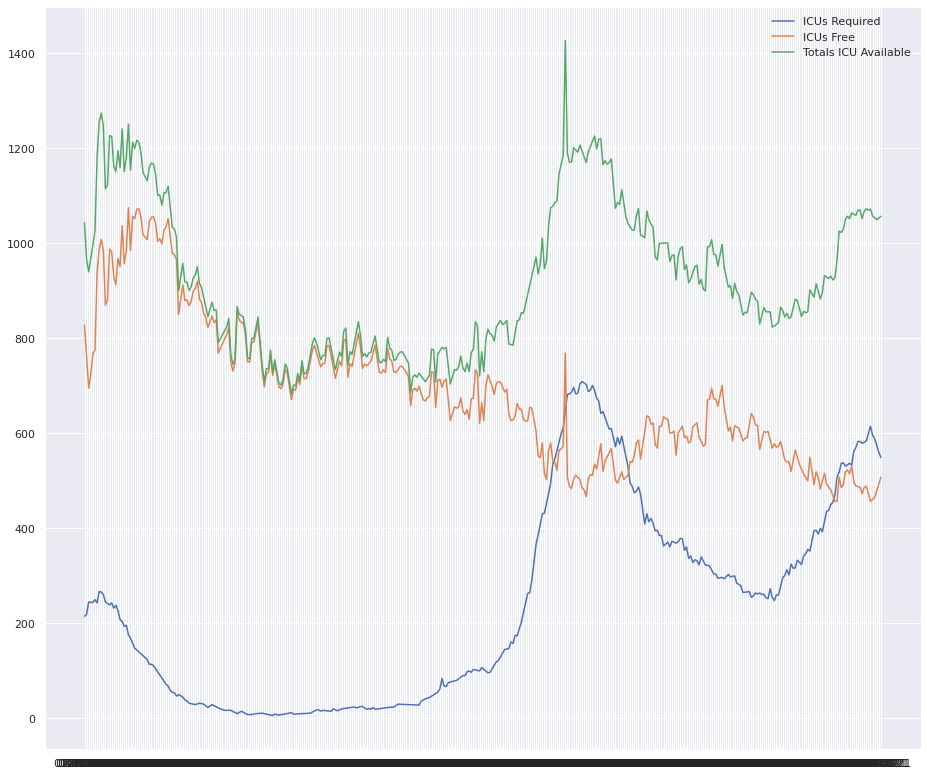

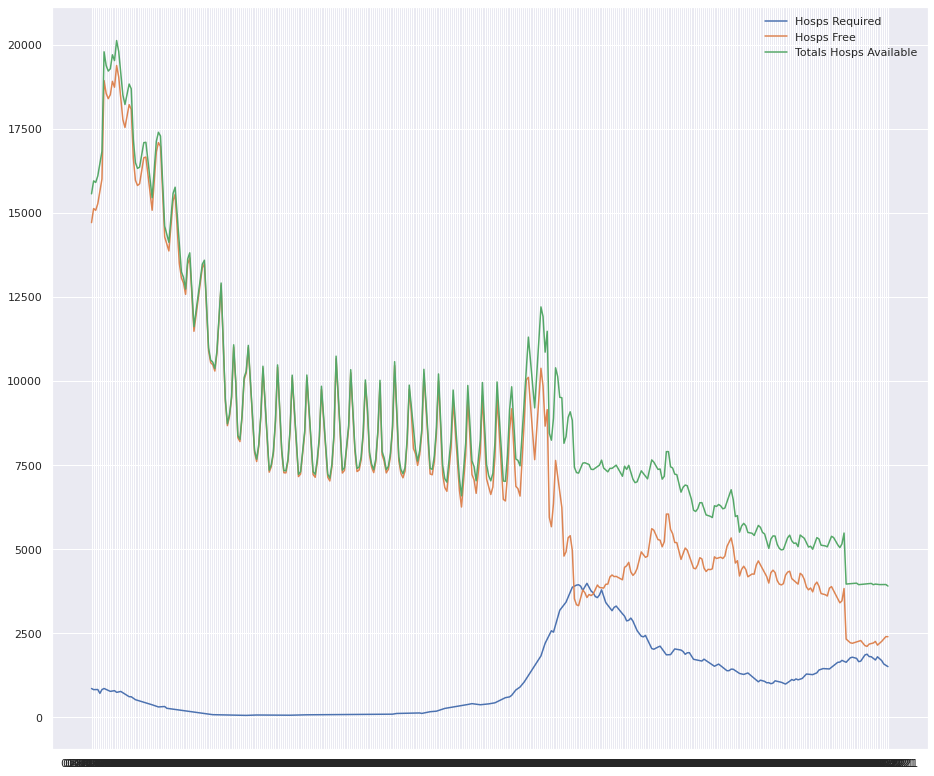

In [874]:
#print(max(aut_hosp_groups['FZICU']))
#print(max(aut_hosp_groups['FZHosp']))
#print(aut_hosp_groups['FZHosp'])
#print(aut_hosp_groups['FZHosp'].shape)
print(aut_hosp_groups)
asd = aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree']
print(sum(asd)/len(asd))
asd = aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree']
print(sum(asd)/len(asd))

plt.plot(aut_hosp_groups['FZICU'], label='ICUs Required')
plt.plot(aut_hosp_groups['FZICUFree'], label='ICUs Free')
plt.plot(aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree'], label='Totals ICU Available')
plt.legend()
plt.show()

plt.plot(aut_hosp_groups['FZHosp'], label='Hosps Required')
plt.plot(aut_hosp_groups['FZHospFree'], label='Hosps Free')
plt.plot(aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree'], label='Totals Hosps Available')
plt.legend()
plt.show()

In [ ]:
x = ('11', '21', '31', '12', '22', '32', '13', '23', '33')

for i in range(0, 10, 1):
    print(x)
    x_new = ()
    x_inv = x[::-1]
    print(i)
    for j in range(0, len(x), 3):
        a, b, c = x_inv[j:j+3][::-1]
        print(a,b,c)
        x_new += c, b, a
    #print(x) 
    x = x_new[::-1]
